### Import libraries

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone
from scipy.stats import beta, linregress
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import time
from tqdm import tqdm
import os
import glob
import warnings
import itertools

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU Name; {torch.cuda.get_device_name(0)}")
    
    warnings.filterwarnings("ignore")

Using Device: cpu


### Data Preparation Function

In [2]:
def download_btc_data(start_year, end_year, timeframe, symbol = 'BTC/USDT'):
    """
    Args:
        start_year (int): 시작 연도
        end_year (int): 종료 연도
        timeframe (str): 데이터 간격 ('1m', '10m' ,'1d')
        symbol (str): 코인 심볼 (기본 BTC/USDT)
    """
    
    save_dir = "data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[INFO] Directory '{save_dir}' created")

    # Create Binance object
    binance = ccxt.binance({
        'enableRateLimit': True,
        'options': {'defaultType': 'future'}
    })

    # Check wheather Binance support timeframe
    if timeframe not in binance.timeframes:
        print(f"[ERROR] '{timeframe} is not a valid timeframe")
        return

    print(f"Target: {symbol} | Timeframe: {timeframe} | Period: {start_year} ~ {end_year}")
    
    safe_symbol = symbol.replace("/", "")

    for year in range(start_year, end_year + 1):
        # Set file path including data folder
        filename = f"{safe_symbol}_{timeframe}_{year}.csv"
        file_path = os.path.join(save_dir, filename)
        
        # Check file existence
        if os.path.exists(file_path):
            print(f"[SKIP] '{filename}' already exists")
            continue
        
        print(f"\n[INFO] Downloading Year: {year}")
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo = timezone.utc)
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo = timezone.utc)

        since = int(start_date.timestamp() * 1000)
        end_timestamp = int(end_date.timestamp() * 1000)

        year_ohlcvs = []

        approx_counts = {
            '1m': 525600, '1d': 365 # 10m Data Not Support in Binance API
        }
        total_candles = approx_counts.get(timeframe, 10000)

        pbar = tqdm(total = total_candles, desc = f"{year} Progress", unit = "candle")

        while since < end_timestamp:
            try:
                ohlcvs = binance.fetch_ohlcv(symbol, timeframe = timeframe, since = since, limit = 1000)

                if not ohlcvs:
                    break

                year_ohlcvs.extend(ohlcvs)

                current_last_time = ohlcvs[-1][0]
                since = current_last_time + 1

                pbar.update(len(ohlcvs))

                if current_last_time >= end_timestamp:
                    break

                time.sleep(0.05)

            except Exception as e:
                print(f"[ERROR] {e}, Retryung")
                time.sleep(3)
                continue

        pbar.close()

        if year_ohlcvs:
            df = pd.DataFrame(year_ohlcvs, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms', utc = True)

            df = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

            df.set_index('datetime', inplace = True)
            df.drop(columns = ['timestamp'], inplace = True)
            
            df.to_csv(file_path)
            print(f"[SUCCESS] Saved {file_path} (Rows: {len(df)})")
        else:
            print(f"[FAIL] No data for {year}")
            
            
def resample_to_10m(start_year, end_year, symbol = 'BTC/USDT'):
    """
    Transform 1m data to 10m data and store to csv file
    """
    save_dir = "data"
    safe_symbol = symbol.replace("/", "")
    
    print(f"Starting Resampling: {symbol} (1m -> 10m) | {start_year} ~ {end_year}")
    
    for year in range(start_year, end_year + 1):
        input_filename = f"{safe_symbol}_1m_{year}.csv"
        input_path = os.path.join(save_dir, input_filename)
        
        output_filename = f"{safe_symbol}_10m_{year}.csv"
        output_path = os.path.join(save_dir, output_filename)
        
        if not os.path.exists(input_path):
            print(f"[SKIP] Source file not found: {input_filename}")
            continue
        
        if os.path.exists(output_path):
            print(f"[SKIP] Target file already exists: {output_filename}")
            continue
        
        print(f"\n[PROCESSING] {input_filename} -> {output_filename}")
        
        try:
            df = pd.read_csv(input_path)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace = True)
            
            ohlcv_dict = {
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            }
            
            df_10m = df.resample('10min').apply(ohlcv_dict)
            
            df_10m.dropna(inplace = True)
            
            df_10m.to_csv(output_path)
            print(f"[DONE] Saved {output_filename} (Rows: {len(df_10m)})")
            
        except Exception as e:
            print(f"[ERROR] Failed to process {year}: {e}")

In [3]:
# Prepare BTC Data for 1m, 1d, 10m
download_btc_data(2020, 2024, timeframe = '1m')
download_btc_data(2020, 2024, timeframe = '1d')
resample_to_10m(2020, 2024)

Target: BTC/USDT | Timeframe: 1m | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1m_2020.csv' already exists
[SKIP] 'BTCUSDT_1m_2021.csv' already exists
[SKIP] 'BTCUSDT_1m_2022.csv' already exists
[SKIP] 'BTCUSDT_1m_2023.csv' already exists
[SKIP] 'BTCUSDT_1m_2024.csv' already exists
Target: BTC/USDT | Timeframe: 1d | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1d_2020.csv' already exists
[SKIP] 'BTCUSDT_1d_2021.csv' already exists
[SKIP] 'BTCUSDT_1d_2022.csv' already exists
[SKIP] 'BTCUSDT_1d_2023.csv' already exists
[SKIP] 'BTCUSDT_1d_2024.csv' already exists
Starting Resampling: BTC/USDT (1m -> 10m) | 2020 ~ 2024
[SKIP] Target file already exists: BTCUSDT_10m_2020.csv
[SKIP] Target file already exists: BTCUSDT_10m_2021.csv
[SKIP] Target file already exists: BTCUSDT_10m_2022.csv
[SKIP] Target file already exists: BTCUSDT_10m_2023.csv
[SKIP] Target file already exists: BTCUSDT_10m_2024.csv


### MF-DFA Function

In [4]:
def mfdfa(data_array, scales, q_list, poly_order = 2):
    """
    Fuction for MFDFA by using Pytorch

    Args:
        batch_data: (Batch_Size, Window_Size) tensor
    """
    if isinstance(data_array, torch.Tensor):
        data_array = data_array.detach().cpu().numpy()
    elif isinstance(data_array, (pd.DataFrame, pd.Series)):
        data_array = data_array.values
    data_array = np.array(data_array)
    
    if data_array.ndim == 1:
        data_array = data_array.reshape(1, -1)
        
    batch_size, N = data_array.shape
    profile = np.cumsum(data_array - np.mean(data_array, axis = 1, keepdims = True), axis = 1)
    
    F_q_s = []
    valid_scales = []
    
    for s in scales:
        if N // s < 4: continue
        valid_scales.append(s)
        N_s = N // s
        
        seg_f = profile[:, :N_s*s].reshape(batch_size, N_s, s)
        seg_b = profile[:, -N_s*s:].reshape(batch_size, N_s, s)
        segments = np.concatenate([seg_f, seg_b], axis = 1)
        
        x_axis = np.linspace(-1, 1, s)
        
        X_design = np.vstack([x_axis**i for i in range(poly_order+1)]).T
        pinv_X = np.linalg.pinv(X_design)
        
        beta = np.matmul(segments, pinv_X.T)
        trend = np.matmul(beta, X_design.T)
        
        resid = segments - trend
        F2 = np.mean(resid**2, axis = 2)
        F2 = np.maximum(F2, 1e-20)
        
        F_vals = []
        for q in q_list:
            if abs(q) < 1e-5:
                f_q = np.exp(0.5 * np.mean(np.log(F2), axis = 1))
            else:
                f_q = np.mean(F2**(q/2), axis = 1)**(1/q)
            F_vals.append(f_q)
            
        F_q_s.append(np.stack(F_vals, axis = 1))
    
    if not F_q_s: return None, None
    
    F_output = np.stack(F_q_s, axis = 2)
    
    return np.array(valid_scales), F_output

def mfdfa_features(price_series, device, window, step):
    print(f"[INFO] Extracting MFDFA Features (Window: {window})")
    
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.iloc[:, 0]
    
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values
    
    windows = []
    indices = []
    
    BATCH_SIZE =   64
    feature_list = []
    
    q_list = np.linspace(-5, 5, 15)
    scales = np.unique(np.logspace(np.log10(10), np.log10(window//4), 10).astype(int))
    
    for t in tqdm(range(window, len(values), step)):
        seg = values[t-window : t]
        windows.append(seg)
        indices.append(log_ret.index[t])
        
        if len(windows) >= BATCH_SIZE:
            batch_tensor = torch.tensor(np.array(windows), dtype = torch.float32).to(device)
            s_vals, F_tensor = mfdfa(batch_tensor, scales, q_list)
            
            if F_tensor is not None:
                F_np = F_tensor
                log_s = np.log(s_vals)
                
                for i in range(len(F_np)):
                    h_q = []
                    for i_q in range(len(q_list)):
                        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i, i_q, :]))
                        h_q.append(slope)
                        
                    h_q = np.array(h_q)
                    delta_H = np.max(h_q) - np.min(h_q)
                    q_arr = np.array(q_list)
                    tau = q_arr * h_q - 1
                    alpha = np.gradient(tau, q_arr)
                    
                    delta_alpha = np.max(alpha) - np.min(alpha)
                    alpha_0 = alpha[len(q_list)//2]
                    
                    feature_list.append([delta_H, delta_alpha, alpha_0])
                    
            windows = []
    if len(feature_list) != len(indices):
        min_len = min(len(feature_list), len(indices))
        feature_list = feature_list[:min_len]
        indices = indices[:min_len]
    
    return pd.DataFrame(feature_list, columns = ['delta_H', 'delta_alpha', 'alpha_0'], index = indices).dropna()


def compute_spectrum(price_series, q_list):
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values

    N = len(values)
    min_scale = 30
    max_scale = N // 10
    scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 30).astype(int))

    s_vals, F_batch = mfdfa(values, scales, q_list, poly_order = 2)

    if F_batch is None: return None

    F_np = F_batch[0]
    log_s = np.log(s_vals)
    h_q = []

    for i_q in range(len(q_list)):
        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i_q, :]))
        h_q.append(slope)

    h_q = np.array(h_q)
    delta_H = np.max(h_q) - np.min(h_q)
    q_arr = np.array(q_list)
    tau = q_arr * h_q - 1
    alpha = np.gradient(tau, q_arr)
    delta_alpha = np.max(alpha) - np.min(alpha)
    f_alpha = q_arr * alpha - tau
    alpha_0 = alpha[len(q_list)//2]

    return{
        'scales': s_vals, 'F_q_s': F_np, 'H_q': h_q,
        'tau_q': tau, 'alpha': alpha, 'f_alpha': f_alpha,
        'delta_H': delta_H, 'delta_alpha': delta_alpha,
        'alpha_0': alpha_0
    }

### LSTM Model

In [11]:
class FlattenLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        
        return self.fc(out[:, -1, :])
    
def prepare_lstm_data(base_df, mfdfa_df, lookback = 5):
    daily_stats = pd.DataFrame()
    daily_stats['Actual_RV'] = (base_df['return']**2).resample('1D').sum()
    daily_stats['GM_Var'] = (base_df['gm_vol']**2).resample('1D').sum()
    
    daily_stats['Actual_Vol'] = np.sqrt(daily_stats['Actual_RV'])
    daily_stats['GM_Vol'] = np.sqrt(daily_stats['GM_Var'])
    daily_stats['Residual'] = daily_stats['Actual_Vol'] - daily_stats['GM_Vol']
    if daily_stats.index.tz is not None:
        daily_stats.index = daily_stats.index.tz_localize(None)
    if mfdfa_df.index.tz is not None:
        mfdfa_df.index = mfdfa_df.index.tz_localize(None)
        
    daily_stats.index = daily_stats.index.normalize()
    mfdfa_df.index = mfdfa_df.index.normalize()
    
    data = pd.merge(daily_stats, mfdfa_df, left_index=True, right_index=True, how='inner').dropna()
    
    features_cols = ['Residual', 'Actual_Vol', 'delta_H', 'delta_alpha', 'alpha_0']
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    scaled_data = scaler_X.fit_transform(data[features_cols])
    scaled_target = scaler_y.fit_transform(data[['Residual']])
    
    X, y = [], []
    for i in range(len(scaled_data) - lookback):
        X.append(scaled_data[i : i + lookback])
        y.append(scaled_target[i+lookback])
        
    return np.array(X), np.array(y), scaler_y, data.index[lookback:], data

def prepare_flatten_features(df_base, mfdfa_df, lags = 144):
    print(f"Data Preprocessing: Create Lag Variables (Lags = {lags})")
    
    mfdfa_cols = ['delta_H', 'delta_alpha', 'alpha_0']
    mfdfa_subset = mfdfa_df[mfdfa_cols].copy()
    
    mfdfa_subset = mfdfa_subset.sort_index()
    mfdfa_subset = mfdfa_subset[~mfdfa_subset.index.duplicated(keep = 'first')]
    
    full_idx = df_base.index
    mfdfa_expanded = mfdfa_subset.reindex(full_idx)
    
    for col in mfdfa_cols:
        mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
    
    df_base = pd.merge(df_base, mfdfa_expanded, left_index = True, right_index = True, how = 'left')
    
    # Target Data 정의: 현재 시점으로부터 24시간의 변동성
    # 10분봉 데이터의 144개 합 -> shift(-144)를 통해 미래 값으로 만듦
    df_base['Future_RV_24h'] = (df_base['return']**2).rolling(window = 144).sum().shift(-144)
    df_base['Future_Vol_24h'] = np.sqrt(df_base['Future_RV_24h'])
    
    
    # 과거 24시간 RV
    df_base['Past_RV'] = (df_base['return']**2).rolling(window=144).sum()
    
    # Base Model 값 매핑
    # 하루동안의 장기 변동성은 동일한 값으로 고정
    df_base['Base_Vol'] = df_base['gm_vol'].interpolate(method = 'cubic').fillna(method = 'bfill') * np.sqrt(144)
    
    
    # Residual 정의
    # 오차 = 실제 RV - GARCH-MIDAS로 예측한 RV
    df_base['Target_Residual'] = df_base['Future_Vol_24h'] - df_base['Base_Vol']
    
    # 데이터 merge
    # Base 결과 + MF-DFA 지표
    data = pd.merge(df_base[['Target_Residual', 'Base_Vol', 'Future_Vol_24h', 'Past_RV', 'close', 'return']],
                    mfdfa_df[['delta_H', 'delta_alpha', 'alpha_0']],
                    left_index = True, right_index = True, how = 'inner')
    
    # Lag Feature 생성
    base_features = ['Past_RV', 'close', 'delta_H', 'delta_alpha', 'alpha_0']
    all_feature_cols = []
    
    for lag in tqdm(range(1, lags + 1), desc = "Create past data columns"):
        for col in base_features:
            col_name = f"{col}_lag{lag}"
            data[col_name] = data[col].shift(lag)
            all_feature_cols.append(col_name)
    
    data.dropna(inplace = True)
    
    print(f"Final Data shape: {data.shape}")
    print(f"The Number of variables in Model: {len(all_feature_cols)}")
    
    return data, all_feature_cols

def prepare_hybrid_flatten_features(df_base, mfdfa_df, lags=144):
    """
    [Optimized Version] PerformanceWarning 해결 및 타임존 처리 포함
    """
    print(f"Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags={lags})")
    
    df = df_base.copy()
    
    # 1. Target & Input 생성
    df['Future_RV_24h'] = (df['return']**2).rolling(window=144).sum().shift(-144)
    df['Future_Vol_24h'] = np.sqrt(df['Future_RV_24h'])
    df['Past_RV'] = (df['return']**2).rolling(window=144).sum()
    df['Base_Vol'] = df['gm_vol'].fillna(method='ffill')
    df['Residual'] = df['Future_Vol_24h'] - df['Base_Vol']
    
    # 2. 날짜 기준 병합 (Timezone Safe)
    if df.index.tz is not None: df.index = df.index.tz_localize(None)
    df['date_key'] = df.index.normalize()
    
    mfdfa_clean = mfdfa_df.copy()
    if mfdfa_clean.index.tz is not None: mfdfa_clean.index = mfdfa_clean.index.tz_localize(None)
    mfdfa_clean.index = pd.to_datetime(mfdfa_clean.index).normalize()
    mfdfa_clean.index.name = 'date_key'
    
    # Debugging
    print(f"   🔎 [Debug] Rows before merge: {len(df)}")
    
    cols_to_keep = ['gm_vol', 'Residual', 'Base_Vol', 'Future_Vol_24h', 'Past_RV', 'close', 'return', 'date_key']
    data = pd.merge(df[cols_to_keep],
                    mfdfa_clean[['delta_H', 'delta_alpha', 'alpha_0']],
                    left_on='date_key', right_index=True, how='left')
    data.drop(columns=['date_key'], inplace=True)

    # -------------------------------------------------------------------------
    # 3. Lag Feature 생성 (pd.concat으로 최적화)
    # -------------------------------------------------------------------------
    base_features = ['Residual', 'Past_RV', 'close', 'delta_H', 'delta_alpha', 'alpha_0']
    
    # (1) 원본 데이터 먼저 리스트에 담기
    feature_dfs = [data] 
    all_feature_cols = []
    
    # (2) Shift된 데이터프레임들을 리스트에 모으기
    print("   🚀 Generating Lag Features (Optimized)...")
    for lag in tqdm(range(1, lags + 1), desc="Lags"):
        # 해당 lag만큼 shift된 데이터프레임 생성 (컬럼명 변경)
        shifted = data[base_features].shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in base_features]
        feature_dfs.append(shifted)
        all_feature_cols.extend(shifted.columns)
        
    # (3) 한 번에 병합 (속도 매우 빠름 & 경고 없음)
    data_final = pd.concat(feature_dfs, axis=1)
    
    # (4) 중복된 원본 컬럼이 생길 수 있으므로 제거 (concat axis=1 특성상)
    #     -> 위 방식은 원본 data + shift된 data들을 합치는 것이므로
    #        data의 컬럼이 중복되지는 않음. 다만 원본 data의 컬럼이 유지됨.
    
    # 결측치 제거
    data_final.dropna(inplace=True)
    
    # 원본 데이터가 너무 커지지 않게 중복 컬럼 정리 (선택사항)
    # 여기서는 feature_dfs[0]이 원본이므로, 자동으로 포함됨.
    
    print(f"   -> Final Data Shape: {data_final.shape} (Features: {len(all_feature_cols)})")
    
    if len(data_final) == 0:
        print("🚨 [Critical] 데이터가 0건입니다. 10분봉 데이터가 GARCH 단계에서 손실되었는지 확인하세요.")
        
    return data_final, all_feature_cols

def run_rolling_flatten_lstm(full_data, feature_cols, train_window = 4320, test_days = 30):
    print(f"\n[INFO] Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    loss_history = []
    
    input_dim =len(feature_cols)
    model = FlattenLSTM(input_dim, hidden_dim = 128, num_layers = 2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144) 
    total_len = len(full_data)
    
    if total_len < train_window + test_len:
        print("데이터 부족으로 가능한 최대 기간만 수행합니다.")
        start_idx = train_window
    else:
        # 정확히 테스트 기간만큼만 뒤에서부터 실행
        start_idx = total_len - test_len

    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    start_idx = train_window
    end_idx = len(full_data)
    
    sim_start = start_idx
    
    pbar = tqdm(range(sim_start, end_idx), desc = "Rolling Update")
    
    for t in pbar:
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df, loss_history

def run_rolling_flatten_lstm_tuned(full_data, feature_cols, hidden_dim, num_layers, train_window, test_days):
    print(f"\n[INFO] Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    
    input_dim =len(feature_cols)
    model = FlattenLSTM(input_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144) 
    total_len = len(full_data)
    start_idx = max(train_window, total_len - test_len)

    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    
    for t in range(start_idx, total_len):
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df

### GARCH-MIDAS Model

In [12]:
def get_beta_weights(K, w1, w2):
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, K)
    weights = beta.pdf(k_vals, w1, w2)
    return weights / weights.sum()

def garch_midas(df_10m, daily_rv, df_x, midas_k = 30):
    print("[INFO] Running GARCH-MIDAS")

    combined_daily = pd.merge(daily_rv[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['exog_x'] = combined_daily[x_col_name].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    combined_daily.dropna(inplace = True)

    merged = df_10m.join(combined_daily[['midas_rv', 'exog_x']], how = 'left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)

    def objective(params):
        m, theta, beta_x = params

        log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_x']
        log_tau = np.clip(log_tau, -20, 20)
        tau = np.sqrt(log_tau)

        try:
            am = arch_model(merged['return'] / np.sqrt(tau), vol = 'Garch', p = 1, q = 1, dist = 'Normal')
            res = am.fit(disp = 'off')
            return -res.loglikelihood
        except:
            return np.inf
        
    initial_guess = [0.1, 0.1, 0.0]
    result = minimize(objective, initial_guess, method = 'L-BFGS-B')
    best_m, best_theta, best_beta_x = result.x

    print(f"[Optimized] Theta(RV): {best_theta:.4f}, Beta(({x_col_name}): {best_beta_x:.4f})")

    final_log_tau = best_m + best_theta * merged['midas_rv'] + best_beta_x * merged['exog_x']
    final_log_tau = np.clip(final_log_tau, -20, 20)
    merged['tau'] = np.sqrt(final_log_tau)

    am_final = arch_model(merged['return'] / np.sqrt(merged['tau']), vol = 'Garch', p = 1, q = 1)
    res_final = am_final.fit(disp = 'off')

    merged['gm_vol'] = np.sqrt(merged['tau'] * res_final.conditional_volatility ** 2)

    return merged

def garch_midas_tuned(df_10m, daily_rv, df_x, midas_k = 30, dist_type = 'Normal'):
    print("[INFO] Running GARCH-MIDAS")

    combined_daily = pd.merge(daily_rv[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['exog_x'] = combined_daily[x_col_name].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    combined_daily.dropna(inplace = True)

    merged = df_10m.join(combined_daily[['midas_rv', 'exog_x']], how = 'left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)

    def objective(params):
        m, theta, beta_x = params

        log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_x']
        log_tau = np.clip(log_tau, -20, 20)
        tau = np.sqrt(log_tau)

        try:
            am = arch_model(merged['return'] / np.sqrt(tau), vol = 'Garch', p = 1, q = 1, dist = dist_type)
            res = am.fit(disp = 'off')
            return -res.loglikelihood
        except:
            return np.inf
        
    initial_guess = [0.1, 0.1, 0.0]
    result = minimize(objective, initial_guess, method = 'L-BFGS-B')
    best_m, best_theta, best_beta_x = result.x

    print(f"[Optimized] Theta(RV): {best_theta:.4f}, Beta(({x_col_name}): {best_beta_x:.4f})")

    final_log_tau = best_m + best_theta * merged['midas_rv'] + best_beta_x * merged['exog_x']
    final_log_tau = np.clip(final_log_tau, -20, 20)
    merged['tau'] = np.sqrt(final_log_tau)

    am_final = arch_model(merged['return'] / np.sqrt(merged['tau']), vol = 'Garch', p = 1, q = 1, dist = dist_type)
    res_final = am_final.fit(disp = 'off')

    merged['gm_vol'] = np.sqrt(merged['tau'] * res_final.conditional_volatility ** 2)

    return merged

def monthly_garch_midas(df_target, mfdfa_df, exog_col = None, midas_k = 30):
    """
    Predict Realized Volatility by using Base Model (GARCH_MIDAS)
    Don't use future data, use past data to estimate parameters
    """
    print(f"[INFO] Base Model Running (Exog: {exog_col if exog_col else 'None'})")
    
    monthly_results = []
    
    month_starts = df_target.resample('MS').first().index
    
    min_train_month = 2
    
    daily_rv_all = (df_target['return']**2).resample('1D').sum().to_frame('rv')
    
    mfdfa_df.index = pd.to_datetime(mfdfa_df.index).normalize()
    
    if exog_col is None:
        df_x_full = pd.DataFrame(0, index = mfdfa_df.index, columns = ['exog_x'])
    else:
        if exog_col not in mfdfa_df.columns:
            raise KeyError(f"Not Exist '{exog_col}' column in MF-DFA data")
        df_x_full = mfdfa_df[[exog_col]].copy()
        df_x_full.columns = ['exog_x']
    
    df_x_full = df_x_full.resample('1D').mean()
    
    print(f"   -> RV 데이터 기간: {daily_rv_all.index.min()} ~ {daily_rv_all.index.max()}")
    print(f"   -> MF-DFA 데이터 기간: {df_x_full.index.min()} ~ {df_x_full.index.max()}")
    
    # 교집합 확인
    common_idx = daily_rv_all.index.intersection(df_x_full.index)
    print(f"   -> 겹치는 날짜 수: {len(common_idx)}일")
    
    if len(common_idx) < 100:
        raise ValueError(f"데이터 날짜가 서로 안 맞습니다! 겹치는 날짜가 {len(common_idx)}개 뿐입니다.")

    pbar = tqdm(range(min_train_month, len(month_starts)), desc = "Monthly Re-fitting")
    
    for i in pbar:
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        if next_month:
            current_slice = df_target[:next_month]
            rv_slice = daily_rv_all[:next_month]
            x_slice = df_x_full[:next_month]
        else:
            current_slice = df_target
            rv_slice = daily_rv_all
            x_slice = df_x_full
            
        try:
            temp_results = garch_midas(current_slice, rv_slice, x_slice)
            mask = (temp_results.index.month == current_month.month) & (temp_results.index.year == current_month.year)
            this_month_vol = temp_results[mask]
            monthly_results.append(this_month_vol)
        except Exception as e:
            print(f"\n Error at {current_month.strftime('%Y-%m')}: {e}")
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        print(f"Complete {len(final_gm_df)} Created")
        return final_gm_df
    else:
        raise ValueError("No result by Failing GARCH0-MDIAS Model Training")
    
def monthly_garch_midas_tuned(df_target, mfdfa_df, exog_col = None, midas_k = 30, dist_type = 'Normal'):
    print(f"[INFO] Base Model Running (Exog: {exog_col if exog_col else 'None'})")
    
    monthly_results = []
    
    month_starts = df_target.resample('MS').first().index
    
    min_train_month = 2
    
    daily_rv_all = (df_target['return']**2).resample('1D').sum().to_frame('rv')
    
    mfdfa_df.index = pd.to_datetime(mfdfa_df.index).normalize()
    
    if exog_col is None:
        df_x_full = pd.DataFrame(0, index = mfdfa_df.index, columns = ['exog_x'])
    else:
        if exog_col not in mfdfa_df.columns:
            raise KeyError(f"Not Exist '{exog_col}' column in MF-DFA data")
        df_x_full = mfdfa_df[[exog_col]].copy()
        df_x_full.columns = ['exog_x']
    
    df_x_full = df_x_full.resample('1D').mean()
    
    for i in range(min_train_month, len(month_starts)):
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        if next_month:
            current_slice = df_target[:next_month]
            rv_slice = daily_rv_all[:next_month]
            x_slice = df_x_full[:next_month]
        else:
            current_slice = df_target
            rv_slice = daily_rv_all
            x_slice = df_x_full
            
        try:
            temp_results = garch_midas_tuned(current_slice, rv_slice, x_slice, midas_k, dist_type)
            mask = (temp_results.index.month == current_month.month) & (temp_results.index.year == current_month.year)
            this_month_vol = temp_results[mask]
            monthly_results.append(this_month_vol)
        except Exception as e:
            print(f"\n Error at {current_month.strftime('%Y-%m')}: {e}")
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        print(f"Complete {len(final_gm_df)} Created")
        return final_gm_df
    else:
        raise ValueError("No result by Failing GARCH0-MDIAS Model Training")

Found 5 files
  -> Loaded 2020
  -> Loaded 2021
  -> Loaded 2022
  -> Loaded 2023
  -> Loaded 2024

 Running MFDFA
   -> Analyzed Merged (5 Years)
   -> Analyzed 2020
   -> Analyzed 2021
   -> Analyzed 2022
   -> Analyzed 2023
   -> Analyzed 2024


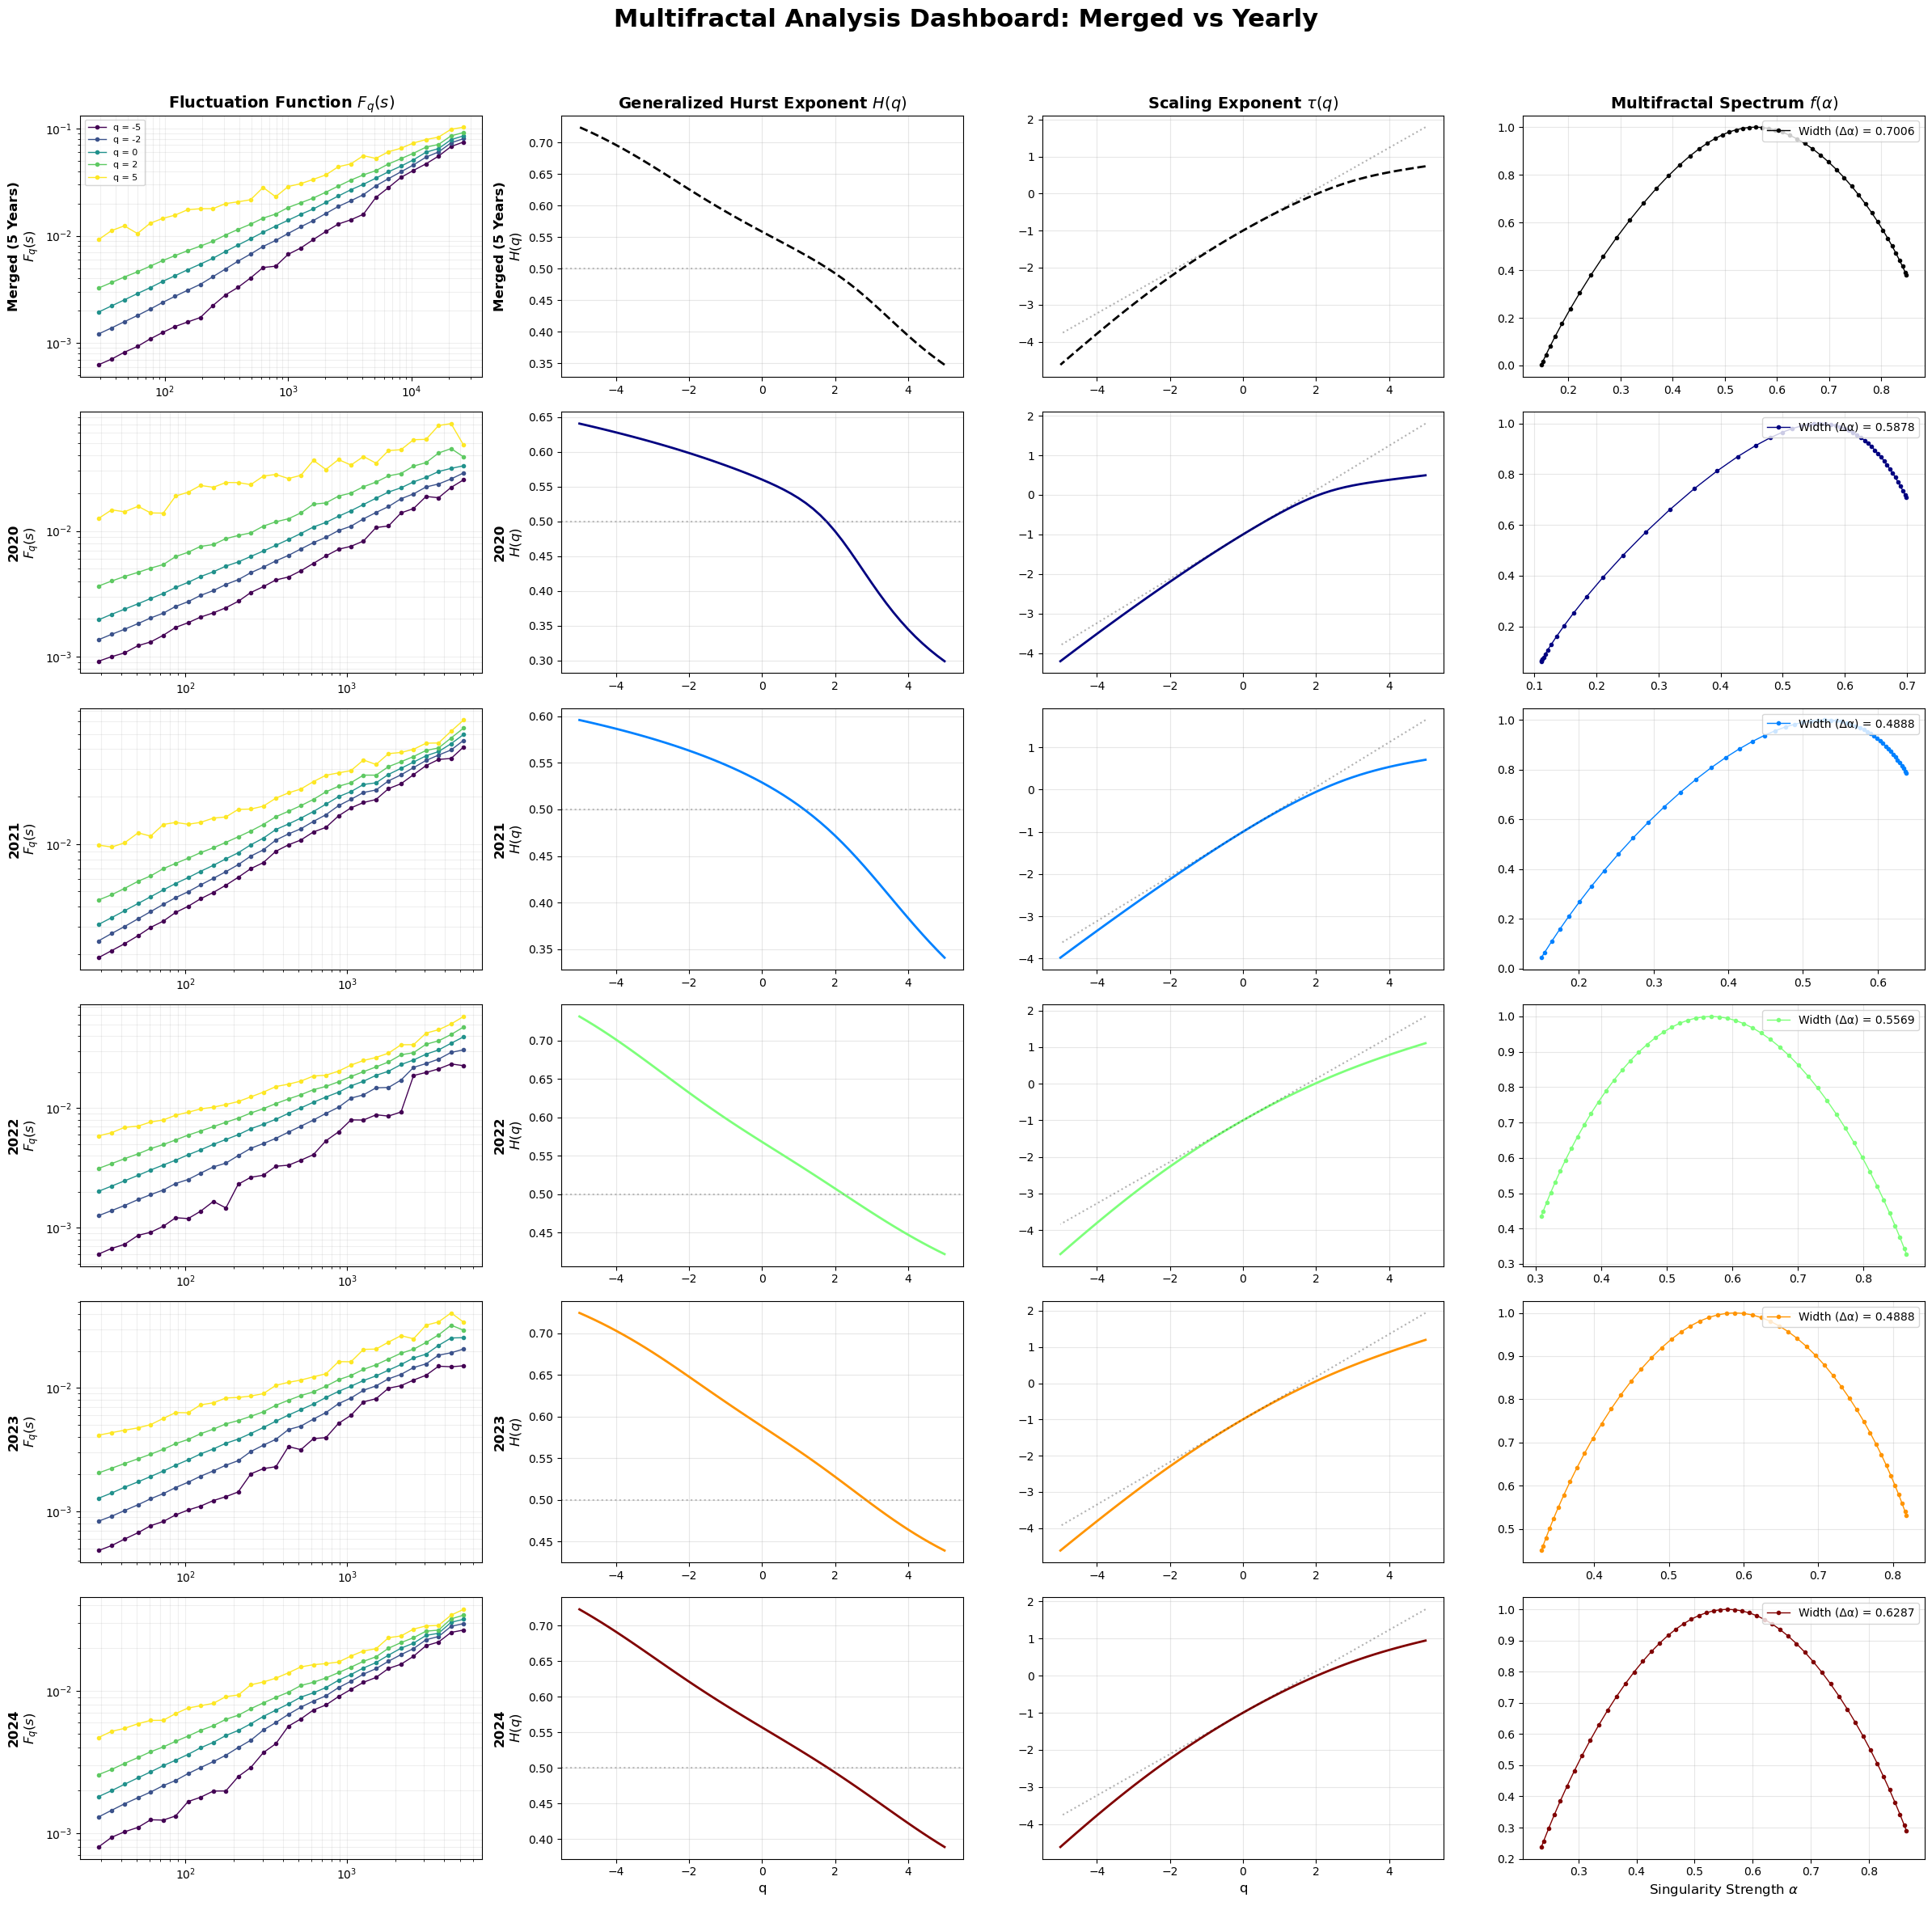

In [7]:
data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("No data")
else:
    print(f"Found {len(files)} files")

datasets = {}

for f in files:
    df = pd.read_csv(f, index_col = 'datetime', parse_dates = True)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close']).diff()
    df.dropna(inplace = True)

    year = str(df.index.year[0])
    datasets[year] = df['close']
    print(f"  -> Loaded {year}")

df_all = pd.concat([pd.read_csv(f, index_col = 'datetime', parse_dates = True) for f in files]).sort_index()
if 'return' not in df_all.columns: df_all['return'] = np.log(df_all['close']).diff()
df_all.dropna(inplace = True)
datasets['Merged (5 Years)'] = df_all['close']

keys = sorted([k for k in datasets.keys() if 'Merged' not in k])
keys.insert(0, 'Merged (5 Years)')

q_list = np.linspace(5, -5, 51)
results = {}

print("\n Running MFDFA")
for name in keys:
    res = compute_spectrum(datasets[name], q_list)
    if res: results[name] = res
    print(f"   -> Analyzed {name}")
fig, axes = plt.subplots(len(keys), 4, figsize=(24, 24))
    
    # 전체 제목
plt.subplots_adjust(top=0.95, wspace = 0.3, hspace = 0.4)
fig.suptitle('Multifractal Analysis Dashboard: Merged vs Yearly', fontsize=22, fontweight='bold')
    
    # 색상 맵 (Merged는 검정, 연도는 다채롭게)
cmap = plt.cm.jet(np.linspace(0, 1, len(keys)-1))
q_plots = [-5, -2, 0, 2, 5]
colors_q = plt.cm.viridis(np.linspace(0, 1, len(q_plots)))
    
for i, name in enumerate(keys):
    res = results[name]
        
        # 색상 설정
    if 'Merged' in name:
        color = 'black'
        style = '--'
    else:
        color = cmap[i-1]
        style = '-'
        
    ax0 = axes[i, 0]
    for j, qv in enumerate(q_plots):
        idx = np.argmin(np.abs(q_list - qv))
        ax0.loglog(res['scales'], res['F_q_s'][idx, :], 'o-',
                   color = colors_q[j], markersize = 3, linewidth = 1, label = f'q = {qv}')
        
    ax0.grid(True, which = 'both', alpha = 0.2)
    ax0.set_ylabel(f"{name}\n$F_q(s)$", fontsize = 12, fontweight = 'bold')
    
    if i == 0:
        ax0.set_title("Fluctuation Function $F_q(s)$", fontsize = 14, fontweight = 'bold')
        ax0.legend(fontsize = 8, loc = 'upper left')
            
        # --- (Col 1) H(q) ---
    ax1 = axes[i, 1]
    ax1.plot(q_list, res['H_q'], linestyle=style, color=color, linewidth=2)
    ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel(f"{name}\n$H(q)$", fontsize=12, fontweight='bold')
    if i == 0: ax1.set_title("Generalized Hurst Exponent $H(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 2) tau(q) ---
    ax2 = axes[i, 2]
    ax2.plot(q_list, res['tau_q'], linestyle=style, color=color, linewidth=2)
        
        # Monofractal Reference Line (비교용 점선)
    h2 = res['H_q'][len(q_list)//2] # q=0 근처의 H값 사용
    ax2.plot(q_list, q_list * h2 - 1, 'k:', alpha=0.3, label='Linear Fit')
        
    ax2.grid(True, alpha=0.3)
    if i == 0: ax2.set_title("Scaling Exponent $\\tau(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 3) f(alpha) ---
    ax3 = axes[i, 3]
        # 스펙트럼 너비(Width) 표시
    label_txt = f"Width (Δα) = {res['delta_alpha']:.4f}"
    ax3.plot(res['alpha'], res['f_alpha'], 'o-', markersize=3, color=color, linewidth=1, label=label_txt)
        
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right', fontsize=10, frameon=True)
    if i == 0: ax3.set_title("Multifractal Spectrum $f(\\alpha)$", fontsize=14, fontweight='bold')
        
        # X축 라벨은 맨 마지막 행에만 표시
    if i == len(keys) - 1:
        ax1.set_xlabel('q', fontsize=12)
        ax2.set_xlabel('q', fontsize=12)
        ax3.set_xlabel('Singularity Strength $\\alpha$', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
def plot_results_by_year(eval_df):
    # 스타일 설정
    sns.set_style("whitegrid")
    plt.rcParams['axes.unicode_minus'] = False
    
    # 인덱스 확인
    if not isinstance(eval_df.index, pd.DatetimeIndex):
        eval_df.index = pd.to_datetime(eval_df.index)

    # 컬럼 이름 안전장치 (Hybrid_Vol로 계산됐을 경우 Hybrid_Pred로 복사)
    if 'Hybrid_Pred' not in eval_df.columns and 'Hybrid_Vol' in eval_df.columns:
        eval_df['Hybrid_Pred'] = eval_df['Hybrid_Vol']

    years = eval_df.index.year.unique()
    print(f"\n총 {len(years)}개 연도에 대해 그래프 생성을 시작합니다...")

    for year in years:
        year_df = eval_df[eval_df.index.year == year]
        if len(year_df) == 0: continue
            
        print(f"   -> {year}년도 그래프 생성 중... ({len(year_df)} rows)")

        # 캔버스 생성 (4행 1열)
        fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
        
        # (1) Actual
        axes[0].plot(year_df.index, year_df['Future_Vol_24h'], color='black', linewidth=1, label='Actual')
        axes[0].set_title(f'[{year}] 1. Actual Volatility', fontsize=14, fontweight='bold')
        axes[0].legend(loc='upper right')
        
        # (2) Base Model
        axes[1].plot(year_df.index, year_df['Base_Vol'], color='blue', linestyle='--', linewidth=1, label='GARCH-MIDAS')
        axes[1].set_title(f'[{year}] 2. Base Model Prediction', fontsize=14, fontweight='bold')
        axes[1].legend(loc='upper right')
        
        # (3) Hybrid Model
        axes[2].plot(year_df.index, year_df['Hybrid_Pred'], color='red', linewidth=1, label='Hybrid LSTM')
        axes[2].set_title(f'[{year}] 3. Hybrid Model Prediction', fontsize=14, fontweight='bold')
        axes[2].legend(loc='upper right')
        
        # (4) Residual Analysis
        target_res = year_df['Future_Vol_24h'] - year_df['Base_Vol']
        pred_res = year_df['Hybrid_Pred'] - year_df['Base_Vol']
        
        axes[3].plot(year_df.index, target_res, color='gray', alpha=0.5, label='Actual Error')
        axes[3].plot(year_df.index, pred_res, color='red', alpha=0.8, linewidth=1, label='Predicted Error')
        axes[3].axhline(0, color='black', linestyle=':', linewidth=1)
        axes[3].set_title(f'[{year}] 4. Residual Analysis', fontsize=14, fontweight='bold')
        axes[3].legend(loc='upper right')
        
        plt.tight_layout()
        
        # 파일 저장
        save_path = f"result_graph_{year}.png"
        plt.savefig(save_path, dpi=100) # 속도를 위해 dpi 100 권장
        plt.close(fig) # 메모리 해제 (필수!)
        
        print(f"저장 완료: {save_path}")

    print("\n모든 연도 그래프 저장이 완료되었습니다!")

In [9]:
# 2021년 데이터 로드
path_10m = "data/BTCUSDT_10m_2021.csv"

df_10m = pd.read_csv(path_10m)

df_10m.columns = [c.lower().strip() for c in df_10m.columns]

date_cols = None
for col in ['timestamp', 'date', 'datetime', 'open_time']:
    if col in df_10m.columns:
        date_col = col
        break
    
if date_col:
    df_10m[date_col] = pd.to_datetime(df_10m[date_col])
    df_10m.set_index(date_col, inplace = True)
else:
    raise KeyError("Can't find date columns")

if 'return' not in df_10m.columns:
    df_10m['return'] = np.log(df_10m['close']).diff() * 100
    
df_10m.dropna(inplace = True)

print(f"데이터 준비 완료. Shape: {df_10m.shape}")
print(f"기간: {df_10m.index.min()} ~ {df_10m.index.max()}")

# MF-DFA 지표 계산
WINDOW_SIZE = 30 * 144

mfdfa_2021 = mfdfa_features(df_10m['close'], DEVICE, window = WINDOW_SIZE, step = 1)

print(f"Complete Calculation of MF-DFA: {mfdfa_2021.shape}")
print("    -> Included index:", mfdfa_2021.columns.tolist())

데이터 준비 완료. Shape: (52559, 6)
기간: 2021-01-01 00:10:00+00:00 ~ 2021-12-31 23:50:00+00:00
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 48238/48238 [02:42<00:00, 296.53it/s]

Complete Calculation of MF-DFA: (48192, 3)
    -> Included index: ['delta_H', 'delta_alpha', 'alpha_0']


In [ ]:
def plot_model_result(eval_df, model_name):
    sns.set_style(style = "whitegrid")

    fig, axes = plt.subplots(2, 1, figsize = (15, 18))

    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
        
    # daily_df = eval_df[['Residual', pred_col]].resample('1D').mean()
    
    axes[0].plot(eval_df.index, eval_df['Residual'],
                 label = 'Residual_GARCH (Actual Error)', color = 'blue', alpha = 0.8)
    axes[0].plot(eval_df.index, eval_df[pred_col],
                 label = 'Residual LSTM (Predicted Error)', color = 'red', alpha = 0.8)
    axes[0].set_title(F"[{model_name}] Residual Analysis (GARCH Error vs LSTM Error)", fontsize = 14, fontweight = 'bold')
    axes[0].axhline(0, color = 'black', linestyle = '--')
    axes[0].legend(loc = 'upper right')
    
    actual_vol = eval_df['Future_Vol_24h']
    garch_vol = eval_df['Base_Vol']
    
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    axes[1].plot(eval_df.index, actual_vol, label = 'Actual RV', color = 'black', alpha = 0.8, linewidth = 2, zorder = 2)
    axes[1].plot(eval_df.index, garch_vol, label = 'GARCH RV', color = 'blue', alpha = 0.6, linewidth = 1, zorder = 1)
    axes[1].plot(eval_df.index, hybrid_vol, label = 'Hybrid RV', color = 'red', alpha = 0.6, linewidth = 1, zorder = 1)
    
    axes[1].set_title(f"[{model_name}] Realized Volatility (RV) Comparison", fontsize = 14, fontweight = 'bold')
    axes[1].legend(loc = 'upper right', frameon = True, shadow = True)
    
    plt.tight_layout()
    plt.show()

scenarios = {
    "1. Benchmark (No Exog)": None,
    "2. Hybrid (with Delta H)": "delta_H",
    # "3. Hybrid (with Delta Alpha)": "delta_alpha"
}

results_summary = []

print("="*80)
print("Compare 3 GARCH-MIDAS Model")
print("="*80)

for model_name, exog_col in scenarios.items():
    print(f"\nRunning Scenario: {model_name}")
    print('-'*60)
    
    try:
        df_base = monthly_garch_midas(df_10m ,mfdfa_2021, exog_col = exog_col)
    except Exception as e:
        print(f"Error: {e}")
        continue
    
    flat_data, features = prepare_flatten_features(df_base, mfdfa_2021, lags = 144)
    
    TRAIN_WINDOW = 4320
    
    TEST_DAYS = (len(flat_data) - TRAIN_WINDOW) // 144
    
    print(f"Rolling LSTM Start (Train Window: 30 days, Test Period: {TEST_DAYS})")
    
    final_result, loss_history = run_rolling_flatten_lstm(
        flat_data, features, train_window = TRAIN_WINDOW, test_days =TEST_DAYS
    )
    
    eval_df = final_result.dropna()
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        raise KeyError(f"🚨 예측 컬럼을 찾을 수 없습니다! 현재 컬럼 목록: {eval_df.columns.tolist()}")
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], hybrid_vol))
    improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
    
    print(f"RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
    
    results_summary.append({
        "Model": model_name,
        "RMSE_Base": rmse_base,
        "RMSE_Hybrid": rmse_hybrid,
        "Improvement (%)": improvement
    })
    
    plot_model_result(eval_df, model_name)
    
print("\n" + "="*80)
print("Final Leaderboard")
print(pd.DataFrame(results_summary))

Compare 3 GARCH-MIDAS Model

Running Scenario: 1. Benchmark (No Exog)
------------------------------------------------------------
[INFO] Base Model Running (Exog: None)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\799737165.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07889. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07889. Parameter
estima

[Optimized] Theta(RV): 1.5670, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08336. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08336. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.0979, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.2765, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 5.0937, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 3.3740, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 4.9504, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\799737165.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04095. Parameter
estima

[Optimized] Theta(RV): 3.9815, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 5.0895, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\799737165.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09796. Parameter
estima

[Optimized] Theta(RV): 5.3609, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\799737165.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09623. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09623. Parameter
estima

[Optimized] Theta(RV): 5.0881, Beta((exog_x): 0.0000)
Complete 43920 Created
Data Preprocessing: Create Lag Variables (Lags = 144)


Create past data columns:   0%|          | 0/144 [00:00<?, ?it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\757362747.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\757362747.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\757362747.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usu

Final Data shape: (43488, 729)
The Number of variables in Model: 720
Rolling LSTM Start (Train Window: 30 days, Test Period: 272)

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34396\757362747.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 272일 (39168 steps)


Rolling Update:   7%|▋         | 2781/39168 [00:40<08:56, 67.86it/s]


KeyboardInterrupt: 

### Parameter Tuning

In [13]:
TUNING_CONFIG = {
    "GARCH": {
        "k_range": range(5, 61, 1),
        "dist_candidates": ['Normal', 't']
    },
    "LSTM": {
        "lags": [72, 144, 288],
        "hidden_dim": [64, 128, 256],
        "num_layers": [1, 2, 3]
    }
}


def check_and_clean_data(df, mfdfa):
    print(f"[{'Data':<10}] {'Start':<20} ~ {'End':<20} | {'Rows':<8} | {'TZ Info'}")
    print("-" * 80)
    
    # 1. 비트코인 데이터 정리
    df_clean = df.copy()
    if df_clean.index.tz is not None:
        df_clean.index = df_clean.index.tz_localize(None) # 타임존 제거
    
    # 2. MF-DFA 데이터 정리
    mf_clean = mfdfa.copy()
    if not isinstance(mf_clean.index, pd.DatetimeIndex):
        mf_clean.index = pd.to_datetime(mf_clean.index)
    if mf_clean.index.tz is not None:
        mf_clean.index = mf_clean.index.tz_localize(None) # 타임존 제거
    mf_clean.index = mf_clean.index.normalize() # 시간 제거 (00:00:00)

    # 3. 로그 출력
    print(f"{'Bitcoin':<10} {str(df_clean.index.min()):<20} ~ {str(df_clean.index.max()):<20} | {len(df_clean):<8} | Cleaned")
    print(f"{'MF-DFA':<10} {str(mf_clean.index.min()):<20} ~ {str(mf_clean.index.max()):<20} | {len(mf_clean):<8} | Cleaned")
    
    # 4. 교집합 확인
    # 비트코인 일별 변환
    daily_btc = df_clean.resample('1D').last()
    common_idx = daily_btc.index.intersection(mf_clean.index)
    
    print("-" * 80)
    if len(common_idx) == 0:
        print("❌ [CRITICAL] 겹치는 날짜가 하나도 없습니다! 데이터를 확인해주세요.")
        return None, None
    else:
        print(f"✅ 교집합 기간: {str(common_idx.min())} ~ {str(common_idx.max())} (총 {len(common_idx)}일)")
        
    return df_clean, mf_clean

def run_fine_tuning(df_base, mfdfa_df):
    
    df_clean, mf_clean = check_and_clean_data(df_base, mfdfa_df)
    if df_clean is None: return
    
    # 2. 수익률 계산
    if 'return' not in df_clean.columns:
        df_clean['return'] = np.log(df_clean['close'] / df_clean['close'].shift(1))
        df_clean.dropna(inplace=True)
    
    daily_rv_all = (df_clean['return']**2).resample('1D').sum().to_frame('rv')
    
    df_base = df_clean.copy()
    mfdfa_df = mf_clean.copy()
    
    
    models = [
        {"name": "1. Benchmark", "col": None},
        {"name": "2. Hybrid (Delta H)", "col": "delta_H"},
        {"name": "3. Hybrid (Delta Alpha)", "col": "delta_alpha"}
    ]
    
    final_report = []
    
    print(f"{'='*80}")
    print(f"- GARCH K: 5~60 (step 1)")
    print(f"   - LSTM Search Space: {len(TUNING_CONFIG['LSTM']['lags']) * len(TUNING_CONFIG['LSTM']['hidden_dim']) * len(TUNING_CONFIG['LSTM']['num_layers'])} combinations")
    print(f"{'='*80}")
    
    for model_info in models:
        model_name = model_info['name']
        exog_col = model_info['col']
        
        print(f"Tuning Model: [{model_name}]")
        
        print(f"Step 1. Scanning GARCH Params (K = 5 ~ 60)")
        best_garch_bic = np.inf
        best_garch_params = {'k': 30, 'dist': 'Normal'}
        best_gm_df = None
        
        garch_candidates = list(itertools.product(TUNING_CONFIG['GARCH']['k_range'],
                                                  TUNING_CONFIG['GARCH']['dist_candidates']))
        
        for k, dist in tqdm(garch_candidates, desc = " > GARCH Search", leave = False):
            try:
                temp_gm_df = garch_midas_estimator(df_base, mfdfa_df, daily_rv_all, midas_k = k, dist_type = dist, exog_col = exog_col)
                
                if temp_gm_df is None or temp_gm_df.empty: continue
                temp_eval = temp_gm_df.copy()
                vol_pred = temp_eval['gm_vol'].resample('1D').mean()
                vol_true = np.sqrt((temp_eval['return']**2).resample('1D').sum())
                
                common = vol_pred.index.intersection(vol_true.index)
                mse = np.mean((vol_true[common] - vol_pred[common]) ** 2)
                
                if mse <= 0: continue
                
                n = len(common)
                num_p = 3 + (1 if dist == 't' else 0)
                bic = n * np.log(mse) + num_p * np.log(n)
                
                if bic < best_garch_bic:
                    best_garch_bic = bic
                    best_garch_params = {'k': k, 'dist': dist}
                    best_gm_df = temp_gm_df
                    
            except Exception as e:
                continue
            
        print(f"Best GARCH: K = {best_garch_params['k']}, Dist = {best_garch_params['dist']}, (BIC: {best_garch_bic:.2f})")
            
        if best_gm_df is None:
            print("GARCH Search Failed")
            best_garch_params = {'k': 30, 'dist': 'Normal'}
            best_gm_df = monthly_garch_midas_tuned(df_base, mfdfa_df, exog_col, midas_k=30, dist_type='Normal')
                
        print("Step 2. Optimizing LSTM Params")
            
        lstm_candidates = list(itertools.product(
            TUNING_CONFIG['LSTM']['lags'],
            TUNING_CONFIG['LSTM']['hidden_dim'],
            TUNING_CONFIG['LSTM']['num_layers']
        ))
            
        best_lstm_rmse = np.inf
        best_lstm_params = {'lags': 144, 'hidden': 128, 'layers': 2}
        success_count = 0
            
        for lags, hidden, layers in tqdm(lstm_candidates, desc = "LSTM Search", leave = False):
            try:
                final_data, feats = prepare_flatten_features(best_gm_df, mfdfa_df, lags = lags)
                    
                result_df, _, = run_rolling_flatten_lstm_tuned(
                    final_data, feats,
                    hidden_dim = hidden, num_layers = layers,
                    train_window = 4320, test_days = 30
                )
                    
                rmse = np.sqrt(((result_df['Future_Vol_24h'] - result_df['Hybrid_Vol'])**2).mean())
                    
                if rmse < best_lstm_rmse:
                    best_lstm_rmse = rmse
                    best_lstm_params = {'lags': lags, 'hidden': hidden, 'layers': layers}
                    success_count += 1
                    
            except Exception as e:
                # [디버깅] 첫 번째 에러만 출력해봄 (어떤 문제인지 확인용)
                if success_count == 0 and lags == lstm_candidates[0][0]: 
                    print(f"   [Debug Warning] LSTM Error: {e}")
                continue    
        print(f"Best LSTM: Lags={best_lstm_params['lags']}, Hidden={best_lstm_params['hidden']}, Layers={best_lstm_params['layers']}")
        print(f"Final Best RMSE: {best_lstm_rmse:.4f}")
            
        final_report.append({
            "Model": model_name,
            "Best_K": best_garch_params['k'],
            "Best_Dist": best_garch_params['dist'],
            "Best_Lags": best_lstm_params['lags'],
            "Best_Hidden": best_lstm_params['hidden'],
            "Best_Layers": best_lstm_params['layers'],
            "Final_RMSE": best_lstm_rmse
        })
    print("\n\n")
    print(f"{'='*100}")
    
    report_df = pd.DataFrame(final_report).sort_values(by="Final_RMSE")
    print(report_df.to_String(index = False))
    
    best_model = report_df.iloc[0]
    
    return report_df

def garch_midas_estimator(df_10m, mfdfa_df, daily_rv, midas_k=30, dist_type='Normal', exog_col=None):
    # 데이터 준비
    mf_copy = mfdfa_df.copy()
    mf_copy.index = pd.to_datetime(mf_copy.index).normalize()
    
    if exog_col is None:
        df_x = pd.DataFrame(0, index=mf_copy.index, columns=['exog_x'])
    else:
        df_x = mf_copy[[exog_col]].copy()
        df_x.columns = ['exog_x']
    df_x = df_x.resample('1D').mean()
    
    # 교집합
    common = daily_rv.index.intersection(df_x.index)
    d_rv = daily_rv.loc[common]
    d_x = df_x.loc[common]
    
    # MIDAS 변수 생성
    combined = pd.merge(d_rv, d_x, left_index=True, right_index=True)
    combined['rv_scaled'] = d_rv['rv'] * 10000
    combined['exog_x'] = d_x['exog_x']
    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined['midas_rv'] = combined['rv_scaled'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
    
    combined['exog_x'] = combined['exog_x'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
    
    combined.dropna(inplace=True)
    if len(combined) < 50: return None
    
    # 10분봉 매핑
    merged = df_10m[['return']].join(combined[['midas_rv', 'exog_x']], how='left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)
    
    # 최적화
    def objective(params):
        m, theta, beta_x = params
        log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_x']
        tau = np.exp(np.clip(log_tau, -5, 10))
        
        # dist에 따른 Likelihood 계산이 복잡하므로 MSE 기반 근사
        return np.mean((merged['return']**2 - tau)**2) # 단순화된 Loss

    try:
        res = minimize(objective, [0.1, 0.1, 0.0], method='L-BFGS-B')
        best_m, best_theta, best_beta_x = res.x
        
        # 결과 생성
        final_log_tau = best_m + best_theta * merged['midas_rv'] + best_beta_x * merged['exog_x']
        merged['tau'] = np.exp(np.clip(final_log_tau, -5, 10))
        
        am = arch_model(merged['return'] / np.sqrt(merged['tau']), vol='Garch', p=1, q=1, dist=dist_type)
        res_final = am.fit(disp='off')
        merged['gm_vol'] = np.sqrt(merged['tau'] * res_final.conditional_volatility ** 2)
        
        merged['gm_vol'] = merged['gm_vol'] / 100 
        merged['return'] = merged['ret_pct'] / 100 
        
        merged['close'] = df_10m['close']
        return merged
    except:
        return None
    
leaderboard = run_fine_tuning(df_10m, mfdfa_2021)

[Data      ] Start                ~ End                  | Rows     | TZ Info
--------------------------------------------------------------------------------
Bitcoin    2021-01-01 00:10:00  ~ 2021-12-31 23:50:00  | 52559    | Cleaned
MF-DFA     2021-01-31 00:00:00  ~ 2021-12-31 00:00:00  | 48192    | Cleaned
--------------------------------------------------------------------------------
✅ 교집합 기간: 2021-01-31 00:00:00 ~ 2021-12-31 00:00:00 (총 335일)
- GARCH K: 5~60 (step 1)
   - LSTM Search Space: 27 combinations
Tuning Model: [1. Benchmark]
Step 1. Scanning GARCH Params (K = 5 ~ 60)


 > GARCH Search:   0%|          | 0/112 [00:00<?, ?it/s]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\4007573030.py:215: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.886e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warni

Best GARCH: K = 30, Dist = Normal, (BIC: inf)
GARCH Search Failed
[INFO] Base Model Running (Exog: None)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02754. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02754. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.8605, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02826. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02826. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 2.9507, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.0985, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 5.0937, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 3.1086, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04326. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2867612192.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04114. Parameter
estim

[Optimized] Theta(RV): 1.1476, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2867612192.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04095. Parameter
estim

[Optimized] Theta(RV): 5.0904, Beta((exog_x): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2867612192.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03869. Parameter
estim

[Optimized] Theta(RV): 1.3645, Beta((exog_x): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03727. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2867612192.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09796. Parameter
estim

[Optimized] Theta(RV): 5.0884, Beta((exog_x): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03313. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2867612192.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09623. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09623. Parameter
estim

[Optimized] Theta(RV): 5.0881, Beta((exog_x): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Complete 43920 Created
Step 2. Optimizing LSTM Params


LSTM Search:   0%|          | 0/27 [00:00<?, ?it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method

Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start
 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   4%|▎         | 1/27 [00:58<25:24, 58.64s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolat

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start
 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
LSTM Search:   7%|▋         | 2/27 [02:21<30:23, 72.92s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future vers

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start
 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
LSTM Search:  11%|█         | 3/27 [04:12<36:11, 90.49s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future vers

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start
 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
LSTM Search:  15%|█▍        | 4/27 [06:58<46:00, 120.03s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future ver

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  19%|█▊        | 5/27 [11:52<1:07:02, 182.85s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpo

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  22%|██▏       | 6/27 [18:37<1:30:27, 258.47s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpo

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  26%|██▌       | 7/27 [24:36<1:37:03, 291.16s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpo

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start
 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
LSTM Search:  30%|██▉       | 8/27 [35:00<2:05:45, 397.12s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future v

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 72)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43560, 369)
The Number of variables in Model: 360

[INFO] Rolling Simulation Start
 -> 총 데이터: 43560, 시뮬레이션 시작 인덱스: 39240
 -> 예측 구간: 약 30일 (4320 steps)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
LSTM Search:  33%|███▎      | 9/27 [50:34<2:49:30, 565.01s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future v

   [Debug Warning] LSTM Error: too many values to unpack (expected 2)
Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  37%|███▋      | 10/27 [52:49<2:02:27, 432.18s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interp

Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  41%|████      | 11/27 [55:47<1:34:31, 354.48s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interp

Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  44%|████▍     | 12/27 [59:06<1:16:49, 307.28s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interp

Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  48%|████▊     | 13/27 [1:02:47<1:05:34, 281.07s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].inte

Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  52%|█████▏    | 14/27 [1:08:37<1:05:25, 301.93s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].inte

Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  56%|█████▌    | 15/27 [1:16:04<1:09:08, 345.75s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].interpolate(method = 'cubic').fillna(method = 'ffill').fillna(method = 'bfill')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mfdfa_expanded[col] = mfdfa_expanded[col].inte

Data Preprocessing: Create Lag Variables (Lags = 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

Final Data shape: (43488, 729)
The Number of variables in Model: 720

[INFO] Rolling Simulation Start


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22220\2571470790.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 43488, 시뮬레이션 시작 인덱스: 39168
 -> 예측 구간: 약 30일 (4320 steps)


KeyboardInterrupt: 

In [10]:

# ==============================================================================
# 1. GARCH Fitting 엔진 (디버깅 모드 ON 🚨)
# ==============================================================================
def fit_garch_midas_debug(df_base, mfdfa_df, daily_rv, midas_k, dist, exog_col):
    try:
        # 1. 데이터 정리
        mf = mfdfa_df.copy()
        if mf.index.tz is not None: mf.index = mf.index.tz_localize(None)
        mf.index = pd.to_datetime(mf.index).normalize()
        
        dr = daily_rv.copy()
        if dr.index.tz is not None: dr.index = dr.index.tz_localize(None)
        dr.index = pd.to_datetime(dr.index).normalize()
        
        # 2. Exog 변수 처리
        if exog_col is None:
            df_x = pd.DataFrame(0.0, index=mf.index, columns=['exog_x'])
        else:
            if exog_col not in mf.columns:
                print(f"   [Debug] Missing Column: {exog_col}")
                return None
            df_x = mf[[exog_col]].copy()
            df_x.columns = ['exog_x']
            
        df_x = df_x.resample('1D').mean().fillna(0)
        
        # 3. 교집합 확인
        common = dr.index.intersection(df_x.index)
        if len(common) < midas_k + 5: 
            # print(f"   [Debug] Not enough overlap: {len(common)} days")
            return None
        
        dr = dr.loc[common]
        d_x = df_x.loc[common]
        
        # 4. MIDAS Weight
        k_vals = np.linspace(1e-6, 1.0-1e-6, midas_k)
        beta_dist = beta.pdf(k_vals, 1.0, 5.0)
        weights = beta_dist / beta_dist.sum()
        
        # 5. MIDAS 변수 생성 (스케일링 적용)
        combined = pd.DataFrame(index=dr.index)
        combined['rv_scaled'] = dr['rv'] * 10000 
        combined['exog_x'] = d_x['exog_x']
        
        combined['midas_rv'] = combined['rv_scaled'].rolling(midas_k).apply(
            lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
        
        combined['exog_midas'] = combined['exog_x'].rolling(midas_k).apply(
            lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
        
        combined.dropna(inplace=True)
        
        # 6. 10분봉 매핑
        df_temp = df_base.copy()
        if df_temp.index.tz is not None: df_temp.index = df_temp.index.tz_localize(None)
        
        # 컬럼 확인
        if 'return' not in df_temp.columns:
            print("   [Debug] 'return' column missing in df_base")
            return None

        df_temp['ret_pct'] = df_temp['return'] * 100 
        
        merged = df_temp[['ret_pct']].join(combined[['midas_rv', 'exog_midas']], how='left')
        merged.fillna(method='ffill', inplace=True)
        merged.dropna(inplace=True)
        
        if len(merged) < 500: 
            # print(f"   [Debug] Too few rows after merge: {len(merged)}")
            return None
        
        # 7. 최적화 (Robust Mode: Nelder-Mead)
        def objective(params):
            m, theta, beta_x = params
            log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_midas']
            tau = np.exp(np.clip(log_tau, -5, 10)) 
            return np.mean((merged['ret_pct']**2 - tau)**2)

        # 초기값 3번 시도
        initial_guesses = [[0.1, 0.1, 0.0], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]]
        res = None
        
        for guess in initial_guesses:
            try:
                # L-BFGS-B 대신 Nelder-Mead 시도 (더 튼튼함)
                res = minimize(objective, guess, method='Nelder-Mead', tol=1e-4)
                if res.success: break
            except:
                continue
                
        if res is None:
            print("   [Debug] Optimization failed for all guesses")
            return None

        m, theta, beta_x = res.x
        
        final_log = m + theta * merged['midas_rv'] + beta_x * merged['exog_midas']
        merged['tau_scaled'] = np.exp(np.clip(final_log, -5, 10))
        
        # 8. GARCH Fitting
        std_resid = merged['ret_pct'] / np.sqrt(merged['tau_scaled'])
        # NaN 체크
        if std_resid.isnull().any() or np.isinf(std_resid).any():
             print("   [Debug] NaN/Inf in residuals")
             return None

        am = arch_model(std_resid, vol='Garch', p=1, q=1, dist=dist)
        res_final = am.fit(disp='off')
        
        gm_vol_pct = np.sqrt(merged['tau_scaled'] * res_final.conditional_volatility**2)
        merged['gm_vol'] = gm_vol_pct / 100 
        merged['return'] = merged['ret_pct'] / 100
        merged['close'] = df_temp['close']
        
        return merged
        
    except Exception as e:
        # ★★★ 여기가 중요합니다: 에러 메시지 출력 ★★★
        print(f"   🚨 [ERROR] GARCH Crashed: {str(e)}")
        return None

# ==============================================================================
# 2. LSTM & Main 실행 함수
# ==============================================================================
# (LSTM 부분은 변경 없음, GARCH 함수만 교체하여 실행)

def run_system_debug(df, mfdfa):
    print("🚀 [System Debug] Tuning Started...")
    
    # 전처리
    if df.index.tz is not None: df.index = df.index.tz_localize(None)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close'] / df['close'].shift(1))
        df.dropna(inplace=True)
    
    daily_rv = (df['return']**2).resample('1D').sum().to_frame('rv')
    
    models = [
        {"name": "1. Benchmark", "col": None},
        {"name": "2. Hybrid (Delta H)", "col": "delta_H"},
        {"name": "3. Hybrid (Delta Alpha)", "col": "delta_alpha"}
    ]
    
    # 디버깅을 위해 범위를 줄임 (빠른 확인용)
    k_range = [30] # 일단 30만 테스트
    dist_list = ['Normal']
    lstm_configs = [(144, 128, 2)] 
    
    final_report = []

    for model_info in models:
        m_name = model_info['name']
        col = model_info['col']
        print(f"\n🔹 Tuning: {m_name}")
        
        best_gm_df = None
        
        # GARCH Test (Debug 함수 호출)
        res = fit_garch_midas_debug(df, mfdfa, daily_rv, 30, 'Normal', col)
        
        if res is not None:
            print("   ✅ GARCH Success!")
            best_gm_df = res
        else:
            print("   ❌ GARCH Failed even in debug mode.")
            continue # 다음 모델로

        # LSTM Test
        print("   > Testing LSTM...")
        try:
            data, feats = prepare_flatten_features(best_gm_df, mfdfa, lags=144)
            res_lstm = run_rolling_flatten_lstm_tuned(data, feats, 128, 2, 4320, 30)
            rmse = np.sqrt(((res_lstm['Future_Vol_24h'] - res_lstm['Hybrid_Vol'])**2).mean())
            print(f"   ✅ LSTM Success! RMSE: {rmse:.4f}")
            
            final_report.append({"Model": m_name, "RMSE": rmse})
            
        except Exception as e:
            print(f"   🚨 [ERROR] LSTM Crashed: {str(e)}")
            
    if final_report:
        print("\nSUCCESS! Leaderboard:")
        print(pd.DataFrame(final_report))
    else:
        print("\nTotal Failure.")

# 실행
run_system_debug(df, mfdfa_2021)

🚀 [System Debug] Tuning Started...

🔹 Tuning: 1. Benchmark
   ❌ GARCH Failed even in debug mode.

🔹 Tuning: 2. Hybrid (Delta H)
   ❌ GARCH Failed even in debug mode.

🔹 Tuning: 3. Hybrid (Delta Alpha)
   ❌ GARCH Failed even in debug mode.

Total Failure.


Loading Datasets...
   -> Loaded 2020
   -> Loaded 2021
   -> Loaded 2022
   -> Loaded 2023
   -> Loaded 2024

🚀 START ROLLING EXPERIMENT: 2020 (Test: Last 30 Days)
   [Step 1] Extracting MFDFA Features...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 336/336 [00:00<00:00, 485.58it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model p

   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWa

[Optimized] Theta(RV): 1.5497, Beta((delta_H): 0.0647)
   [Step 3] Preparing Rolling Data (Flattening)...
Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags=144)
   🔎 [Debug] Rows before merge: 44064
   🚀 Generating Lag Features (Optimized)...


Lags: 100%|██████████| 144/144 [00:00<00:00, 749.64it/s]


   -> Final Data Shape: (41473, 874) (Features: 864)
   [Step 3.5] Safety Check (Outlier Clipping)...
      -> Rescaling Base Model by 12.6432
   [Step 4] Running Rolling Simulation (Test: 30 days)...

[INFO] Rolling Simulation Start
 -> 총 데이터: 41329, 시뮬레이션 시작 인덱스: 37009
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 37009/37009 [09:02<00:00, 68.27it/s]


   [Result] RMSE Base: 1.7359 -> Hybrid: 1.6717 (3.70% Improved)
   -> Graph saved to Rolling_Result_2020.png


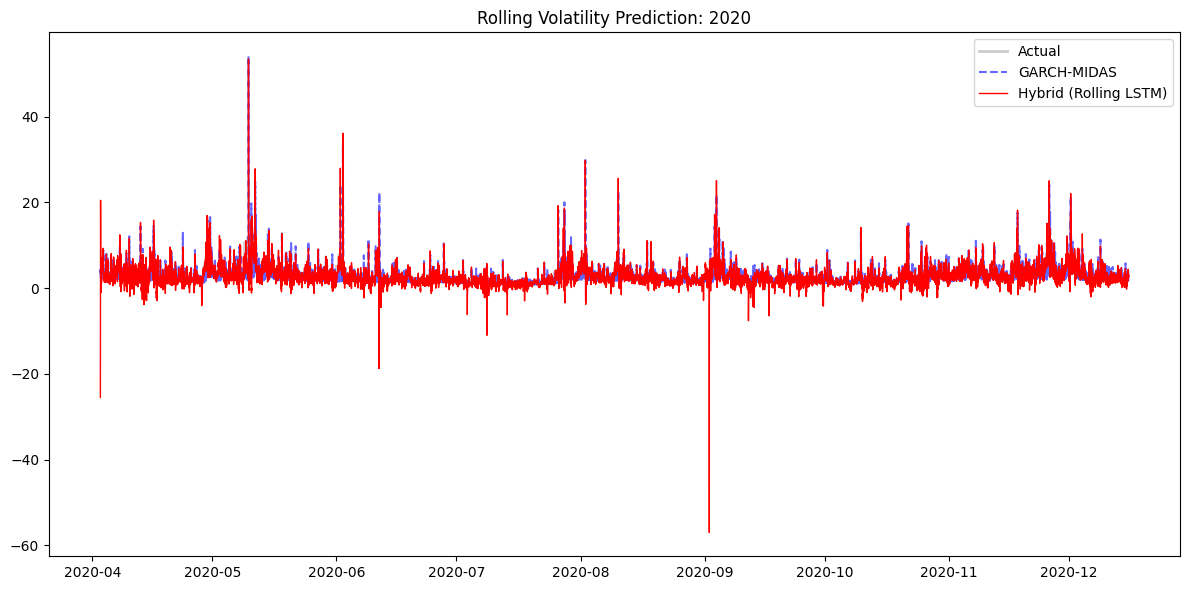


🚀 START ROLLING EXPERIMENT: 2021 (Test: Last 30 Days)
   [Step 1] Extracting MFDFA Features...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 627.25it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model p

   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 5.0880, Beta((delta_H): 0.0848)
   [Step 3] Preparing Rolling Data (Flattening)...
Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags=144)
   🔎 [Debug] Rows before merge: 43920
   🚀 Generating Lag Features (Optimized)...


Lags: 100%|██████████| 144/144 [00:00<00:00, 874.30it/s]


   -> Final Data Shape: (41473, 874) (Features: 864)
   [Step 3.5] Safety Check (Outlier Clipping)...
      -> Rescaling Base Model by 12.0851
   [Step 4] Running Rolling Simulation (Test: 30 days)...

[INFO] Rolling Simulation Start
 -> 총 데이터: 41329, 시뮬레이션 시작 인덱스: 37009
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 37009/37009 [09:01<00:00, 68.37it/s]


   [Result] RMSE Base: 2.5947 -> Hybrid: 1.5928 (38.62% Improved)
   -> Graph saved to Rolling_Result_2021.png


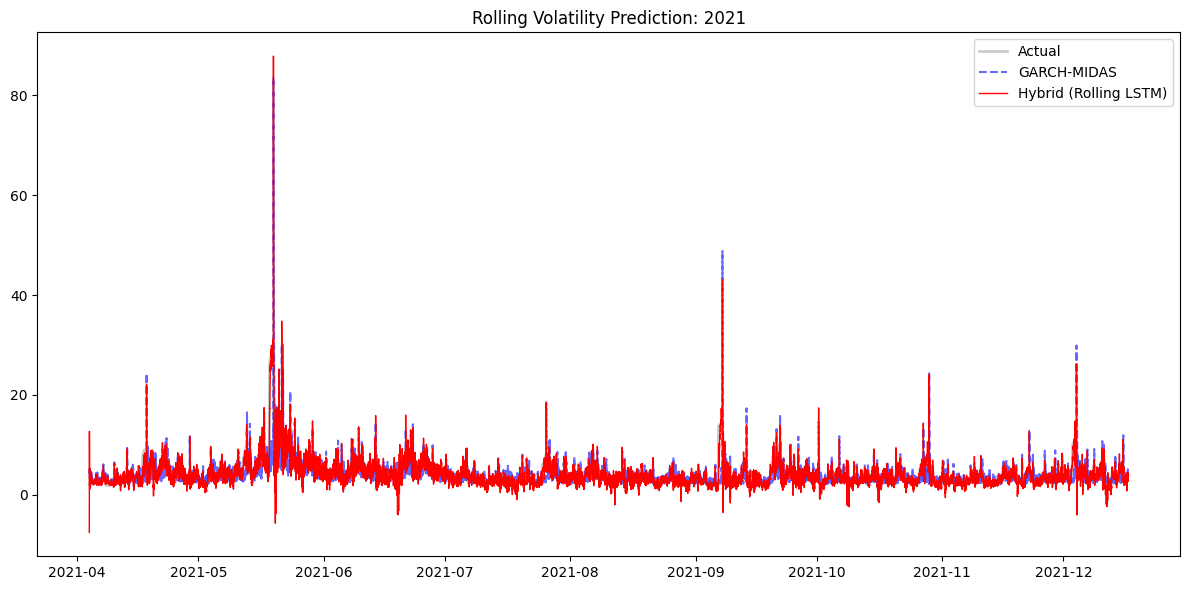


🚀 START ROLLING EXPERIMENT: 2022 (Test: Last 30 Days)
   [Step 1] Extracting MFDFA Features...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 618.83it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model p

   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
c:\Users\kjw02\anaconda3\Lib\site-packag

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
   [Step 3] Preparing Rolling Data (Flattening)...
Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags=144)
   🔎 [Debug] Rows before merge: 43920
   🚀 Generating Lag Features (Optimized)...


Lags: 100%|██████████| 144/144 [00:00<00:00, 845.65it/s]


   -> Final Data Shape: (41473, 874) (Features: 864)
   [Step 3.5] Safety Check (Outlier Clipping)...
      -> Rescaling Base Model by 11.7068
   [Step 4] Running Rolling Simulation (Test: 30 days)...

[INFO] Rolling Simulation Start
 -> 총 데이터: 41329, 시뮬레이션 시작 인덱스: 37009
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 37009/37009 [09:02<00:00, 68.25it/s]


   [Result] RMSE Base: 1.6025 -> Hybrid: 0.8166 (49.04% Improved)
   -> Graph saved to Rolling_Result_2022.png


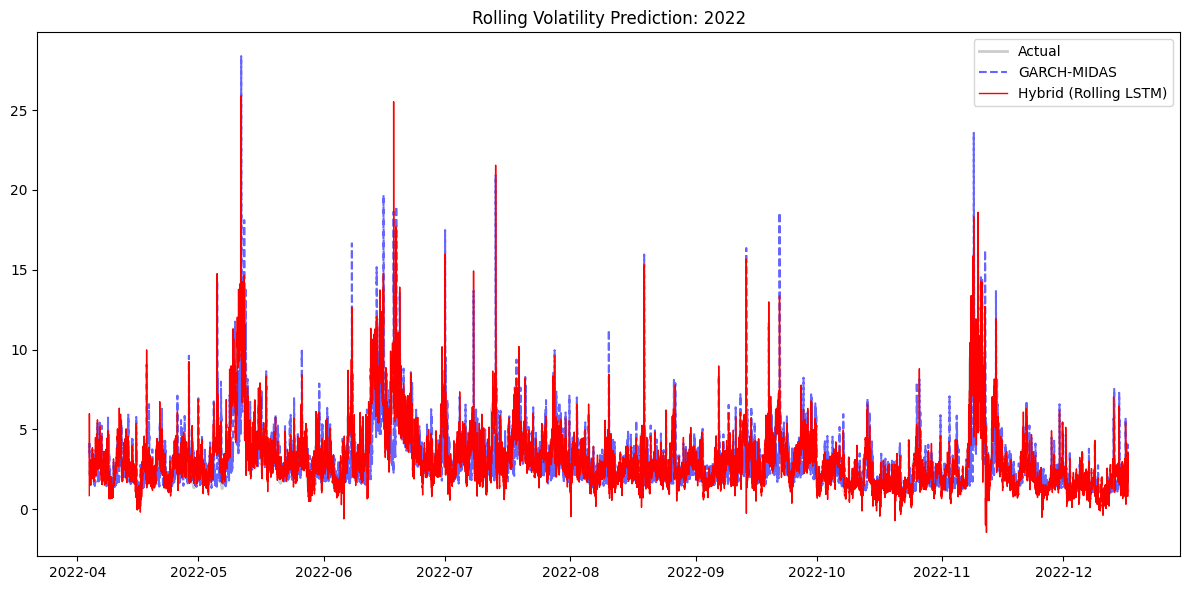


🚀 START ROLLING EXPERIMENT: 2023 (Test: Last 30 Days)
   [Step 1] Extracting MFDFA Features...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 623.38it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model p

   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01465. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01465. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 20.3657, Beta((delta_H): 1.7488)
   [Step 3] Preparing Rolling Data (Flattening)...
Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags=144)
   🔎 [Debug] Rows before merge: 43920
   🚀 Generating Lag Features (Optimized)...


Lags: 100%|██████████| 144/144 [00:00<00:00, 933.10it/s]


   -> Final Data Shape: (41473, 874) (Features: 864)
   [Step 3.5] Safety Check (Outlier Clipping)...
      -> Rescaling Base Model by 13.1569
   [Step 4] Running Rolling Simulation (Test: 30 days)...

[INFO] Rolling Simulation Start
 -> 총 데이터: 41329, 시뮬레이션 시작 인덱스: 37009
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 37009/37009 [09:02<00:00, 68.21it/s]


   [Result] RMSE Base: 1.3639 -> Hybrid: 0.8799 (35.49% Improved)
   -> Graph saved to Rolling_Result_2023.png


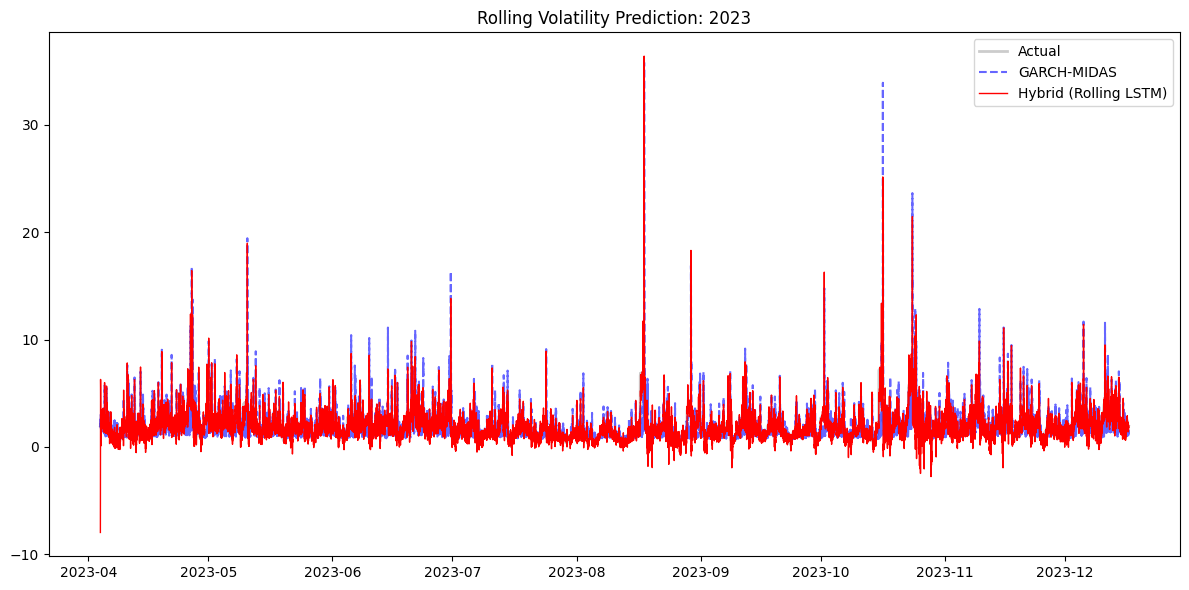


🚀 START ROLLING EXPERIMENT: 2024 (Test: Last 30 Days)
   [Step 1] Extracting MFDFA Features...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 336/336 [00:00<00:00, 618.59it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0585. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model pa

   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0585. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0585. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarn

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
   [Step 3] Preparing Rolling Data (Flattening)...
Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags=144)
   🔎 [Debug] Rows before merge: 44064
   🚀 Generating Lag Features (Optimized)...


Lags: 100%|██████████| 144/144 [00:00<00:00, 919.60it/s]


   -> Final Data Shape: (41473, 874) (Features: 864)
   [Step 3.5] Safety Check (Outlier Clipping)...
      -> Rescaling Base Model by 12.0265
   [Step 4] Running Rolling Simulation (Test: 30 days)...

[INFO] Rolling Simulation Start
 -> 총 데이터: 41329, 시뮬레이션 시작 인덱스: 37009
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 37009/37009 [09:04<00:00, 67.95it/s]


   [Result] RMSE Base: 1.3297 -> Hybrid: 0.9332 (29.82% Improved)
   -> Graph saved to Rolling_Result_2024.png


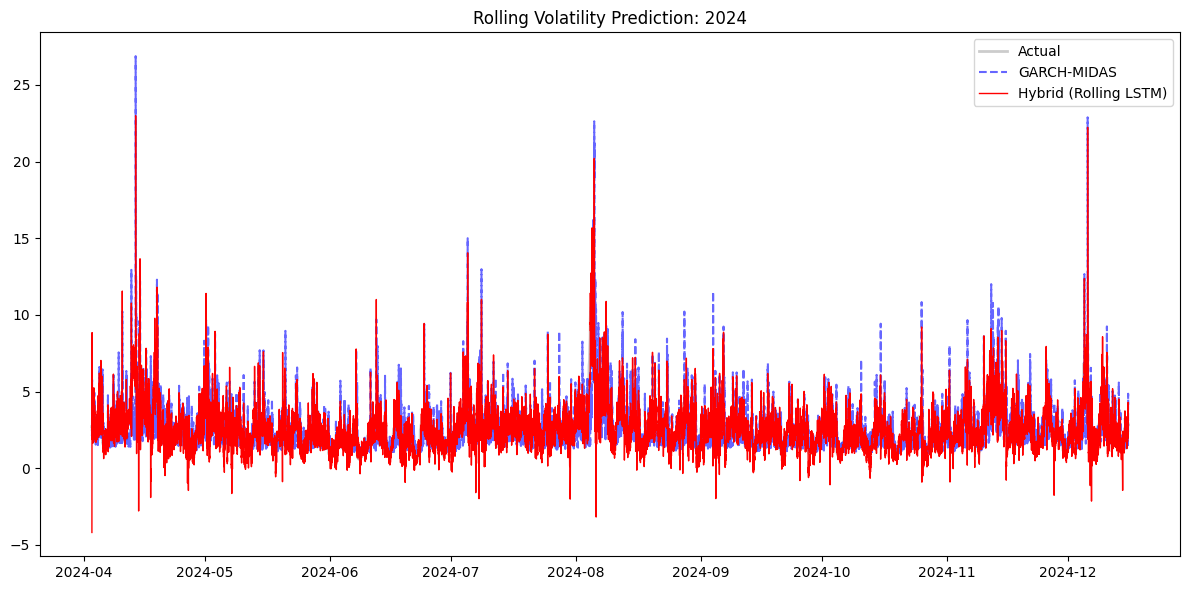


🚀 START ROLLING EXPERIMENT: Merged (5 Years) (Test: Last 30 Days)
   [Step 1] Extracting MFDFA Features...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 1797/1797 [00:03<00:00, 587.53it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 8.3873, Beta((delta_H): 4.4816)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3332781110.py:107: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Base_Vol'] = df['gm_vol'].fillna(method='ffill')


   [Step 3] Preparing Rolling Data (Flattening)...
Data Preprocessing (Hybrid): Merging 10m GARCH + Daily MFDFA (Lags=144)
   🔎 [Debug] Rows before merge: 254448
   🚀 Generating Lag Features (Optimized)...


Lags: 100%|██████████| 144/144 [00:00<00:00, 193.09it/s]


   -> Final Data Shape: (253441, 874) (Features: 864)
   [Step 3.5] Safety Check (Outlier Clipping)...
      -> Rescaling Base Model by 12.6021
   [Step 4] Running Rolling Simulation (Test: 30 days)...

[INFO] Rolling Simulation Start
 -> 총 데이터: 253297, 시뮬레이션 시작 인덱스: 248977
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 248977/248977 [1:02:52<00:00, 66.01it/s]


   [Result] RMSE Base: 1.9413 -> Hybrid: 1.5447 (20.43% Improved)
   -> Graph saved to Rolling_Result_Merged (5 Years).png


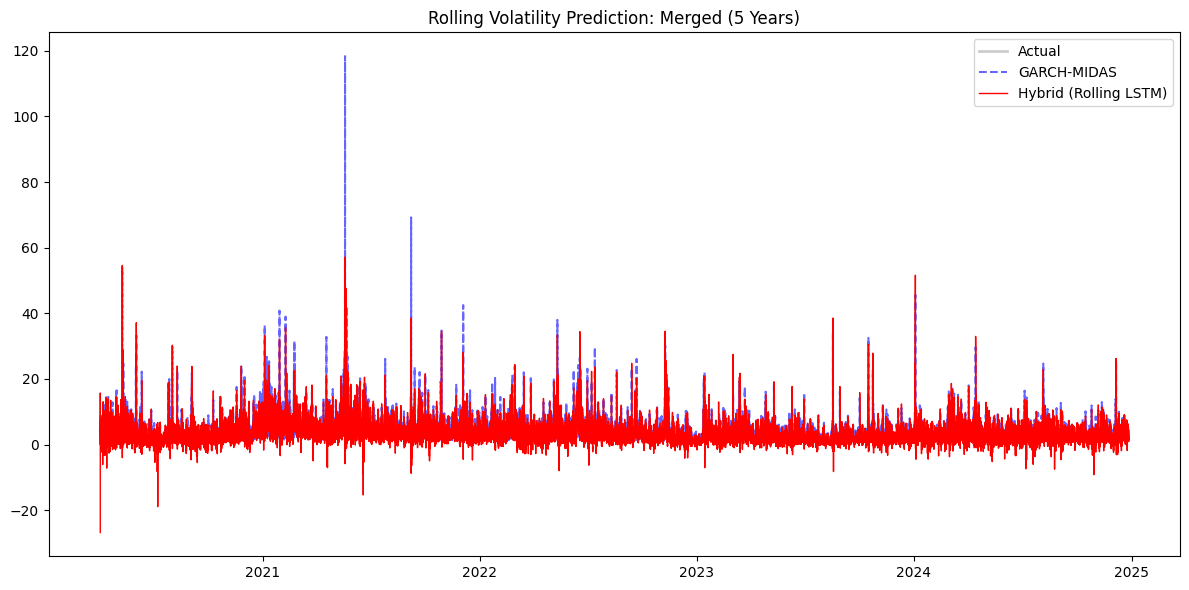


FINAL PERFORMANCE SUMMARY
         Dataset  RMSE_Base  RMSE_Hybrid  MAE_Hybrid  Improvement(%)
            2020     1.7359       1.6717      1.0203          3.6970
            2021     2.5947       1.5928      0.8793         38.6158
            2022     1.6025       0.8166      0.5358         49.0431
            2023     1.3639       0.8799      0.5330         35.4869
            2024     1.3297       0.9332      0.6344         29.8206
Merged (5 Years)     1.9413       1.5447      1.0047         20.4293


In [ ]:

# def run_hybrid_experiment(name, df_data, test_days = 30):
#     print(f"\n{'='*60}")
#     print(f"🚀 START ROLLING EXPERIMENT: {name} (Test: Last {test_days} Days)")
#     print(f"{'='*60}")
    
#     # -------------------------------------------------------------------------
#     # 1. 기본 데이터 전처리 (GARCH용 Daily RV 계산)
#     # -------------------------------------------------------------------------
#     if 'return' not in df_data.columns:
#         df_data['return'] = np.log(df_data['close'] / df_data['close'].shift(1)) * 100
#     df_data.dropna(inplace=True)
    
#     # GARCH-MIDAS는 일별 변동성(rv)이 필요함
#     daily_rv = (df_data['return']**2).resample('1D').sum().to_frame('rv')
    
#     # MFDFA 파라미터
#     candles_per_day = 144
#     window_days = 30
#     window_size = window_days * candles_per_day
    
#     # -------------------------------------------------------------------------
#     # 2. MFDFA 특징 추출
#     # -------------------------------------------------------------------------
#     print(f"   [Step 1] Extracting MFDFA Features...")
#     mfdfa_df = mfdfa_features(df_data['close'], DEVICE, window=window_size, step=candles_per_day)
    
#     if mfdfa_df is None or len(mfdfa_df) == 0:
#         print("   [Skip] MFDFA 결과 없음")
#         return None

#     # 인덱스 시간 정규화 (시간 제거)
#     mfdfa_df.index = pd.to_datetime(mfdfa_df.index).normalize()
    
#     # -------------------------------------------------------------------------
#     # 3. GARCH-MIDAS 실행 (Base Model)
#     # -------------------------------------------------------------------------
#     print("   [Step 2] Running GARCH-MIDAS...")
#     try:
#         df_gm = garch_midas(df_data, daily_rv, mfdfa_df)
#     except Exception as e:
#         print(f"   [Skip] GARCH 모델 실패: {e}")
#         return None

#     # -------------------------------------------------------------------------
#     # 4. Rolling LSTM 데이터 준비 (10분봉 단위 유지!)
#     # -------------------------------------------------------------------------
#     print("   [Step 3] Preparing Rolling Data (Flattening)...")
    
#     # [핵심 변경] 일별 변환 함수 대신, 아까 만든 10분봉용 함수 사용
#     flat_data, features = prepare_hybrid_flatten_features(df_gm, mfdfa_df, lags=144)
    
#     # -------------------------------------------------------------------------
#     # 🚑 [안전장치] GARCH 폭등(Outlier) 제어 및 스케일링
#     # -------------------------------------------------------------------------
#     print("   [Step 3.5] Safety Check (Outlier Clipping)...")
    
#     # 1) 이상치 자르기 (20을 넘으면 자름)
#     flat_data['Base_Vol'] = flat_data['Base_Vol'].clip(upper=20.0)
    
#     # 2) 스케일 보정 (평균 맞추기)
#     mean_actual = flat_data['Future_Vol_24h'].mean()
#     mean_base = flat_data['Base_Vol'].mean()
    
#     if mean_base > 0:
#         scale_ratio = mean_actual / mean_base
#         # 차이가 너무 크면(20% 이상) 보정
#         if abs(1 - scale_ratio) > 0.2:
#             print(f"      -> Rescaling Base Model by {scale_ratio:.4f}")
#             flat_data['Base_Vol'] = flat_data['Base_Vol'] * scale_ratio
            
#     # 3) Residual 재계산 (필수)
#     flat_data['Residual'] = flat_data['Future_Vol_24h'] - flat_data['Base_Vol']
    
#     # 4) Lag Feature 업데이트
#     for col in features:
#         if 'Residual_lag' in col:
#             lag_num = int(col.split('lag')[-1])
#             flat_data[col] = flat_data['Residual'].shift(lag_num)
#     flat_data.dropna(inplace=True)

#     # -------------------------------------------------------------------------
#     # 5. Rolling Simulation 실행 (Online Learning)
#     # -------------------------------------------------------------------------
#     print(f"   [Step 4] Running Rolling Simulation (Test: {test_days} days)...")
    
#     # 우리가 만든 10분 Rolling 함수 호출
#     final_result, loss_history = run_rolling_flatten_lstm(
#         flat_data, 
#         features, 
#         train_window=4320, # 30일치 학습
#         test_days=test_days 
#     )
    
#     if final_result is None:
#         print("   [Error] 시뮬레이션 결과 없음")
#         return None
        
#     # -------------------------------------------------------------------------
#     # 6. 결과 정리 및 시각화
#     # -------------------------------------------------------------------------
#     eval_df = final_result.dropna()
    
#     rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
#     rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol']))
#     mae_hybrid = mean_absolute_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol'])
#     improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
    
#     print(f"   [Result] RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
    
#     # 그래프 그리기 (파일 저장)
#     plt.figure(figsize=(12, 6))
#     plt.plot(eval_df.index, eval_df['Future_Vol_24h'], 'k-', alpha=0.2, linewidth=2, label='Actual')
#     plt.plot(eval_df.index, eval_df['Base_Vol'], 'b--', alpha=0.6, label='GARCH-MIDAS')
#     plt.plot(eval_df.index, eval_df['Hybrid_Vol'], 'r-', linewidth=1, label='Hybrid (Rolling LSTM)')
#     plt.title(f"Rolling Volatility Prediction: {name}")
#     plt.legend()
#     plt.tight_layout()
    
#     save_path = f"Rolling_Result_{name}.png"
#     plt.savefig(save_path)
#     print(f"   -> Graph saved to {save_path}")
#     plt.show()
    
#     return {
#         'Dataset': name,
#         'RMSE_Base': rmse_base,
#         'RMSE_Hybrid': rmse_hybrid,
#         'MAE_Hybrid': mae_hybrid,
#         'Improvement(%)': improvement
#     }


# data_dir = "data"
# files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

# if not files:
#     print("데이터 파일이 없습니다.")
# else:
#     datasets = {}
#     df_list = []
    
#     print("Loading Datasets...")
#     for f in files:
#         df = pd.read_csv(f, index_col='datetime', parse_dates=True)
#         year = str(df.index.year[0])
#         datasets[year] = df
#         df_list.append(df)
#         print(f"   -> Loaded {year}")
        
#     df_all = pd.concat(df_list).sort_index()
#     datasets['Merged (5 Years)'] = df_all
    
#     keys = sorted([k for k in datasets.keys() if 'Merged' not in k]) + ['Merged (5 Years)']
    
#     summary_results = []
    
#     for name in keys:
#         df_target = datasets[name].copy()
        
#         res = run_hybrid_experiment(name, df_target)
#         if res:
#             summary_results.append(res)
            
#     print("\n" + "="*60)
#     print("FINAL PERFORMANCE SUMMARY")
#     print("="*60)
#     summary_df = pd.DataFrame(summary_results)
#     print(summary_df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
#     print("="*60)

In [ ]:
# if __name__ == "__main__":
#     # 데이터셋 존재 여부 확인
#     if 'datasets' in locals() and 'Merged (5 Years)' in datasets:
#         # 1. 데이터 로드 및 수익률 계산
#         target_df = datasets['Merged (5 Years)'][['close']].copy()
#         if 'return' not in target_df.columns:
#             target_df['return'] = np.log(target_df['close']).diff() * 100
#         target_df.dropna(inplace=True)
        
        
#         # 2. MF-DFA 추출 (메모리에 없으면 실행 - 시간 소요 주의)
#         if 'mfdfa_df' not in locals():
#             print("MF-DFA 데이터가 없어 새로 계산합니다. (오래 걸릴 수 있음)")
#             # step=1 (10분 단위), window=4320 (30일)
#             mfdfa_df = mfdfa_features(target_df['close'], DEVICE, window=30*144, step=1)
            
#         # 3. Base Model (GARCH-MIDAS) 실행
#         df_base = monthly_garch_midas(target_df, mfdfa_df)
        
#         # 4. Feature Flattening (회귀분석형 데이터셋 생성)
#         # lags=144: 과거 24시간 데이터를 옆으로 펼칩니다.
#         flat_data, features = prepare_flatten_features(df_base, mfdfa_df, lags=144)
        
#         print("\n🔍 [DEBUG] 데이터 스케일 점검")
#         print("-" * 50)
#         print(f"1. Actual (Future_Vol_24h) 통계:\n{flat_data['Future_Vol_24h'].describe()}")
#         print("-" * 50)
#         print(f"2. Base Model (Base_Vol) 통계:\n{flat_data['Base_Vol'].describe()}")
#         print("-" * 50)
#         print(f"3. Residual (Target) 통계:\n{flat_data['Target_Residual'].describe()}")
        
#         # 5. Rolling Simulation 실행
#         # 학습 윈도우: 30일 (4320개)
#         TEST_DAYS = 30
#         final_result, loss_history = run_rolling_flatten_lstm(
#             flat_data, features, train_window=4320, test_days = TEST_DAYS
#             )
        
#         # 6. 결과 평가 (RMSE, MAE, Improvement)
#         eval_df = final_result.dropna()
        
#         # Target_Residual = 실제 오차 (정답지)
#         eval_df['Target_Residual'] = eval_df['Future_Vol_24h'] - eval_df['Base_Vol']
#         # Predicted_Residual = LSTM이 예측한 오차
#         eval_df['Predicted_Residual'] = eval_df['Hybrid_Vol'] - eval_df['Base_Vol']
        
#         rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
#         rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol']))
        
#         improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
        
#         print("\n" + "="*60)
#         print(f"FINAL HYBRID MODEL RESULT")
#         print("="*60)
#         print(f" RMSE (Base GARCH) : {rmse_base:.4f}")
#         print(f" RMSE (Hybrid LSTM): {rmse_hybrid:.4f}")
#         print(f" 개선율 (Improvement): {improvement:.2f}%")
#         print("-" * 60)
#         print("="*60)
        
#         # # 7. 결과 시각화
        
#         plot_results_by_year(eval_df)
#         # fig, axes = plt.subplots(2, 1, figsize = (14, 10), gridspec_kw = {'height_ratios': [2, 1]})
        
#         # ax1 = axes[0]
#         # ax1.plot(eval_df.index, eval_df['Future_Vol_24h'],
#         #          color = 'black', linewidth = 4, alpha = 0.2, label = 'Actual')
#         # ax1.plot(eval_df.index, eval_df['Base_Vol'],
#         #          color = 'blue', linestyle = '--', linewidth = 1.5, alpha = 0.7, label = 'Base Model')
#         # ax1.plot(eval_df.index, eval_df['Hybrid_Vol'],
#         #          color = 'red', linewidth = 1.5, alpha = 1.0, label = 'Hybrid')
#         # ax1.set_title(f"Volatility Prediction (Rolling Update: {TEST_DAYS} Days)", fontsize = 16, fontweight = 'bold')
#         # ax1.set_ylabel("Volatility", fontsize = 12)
#         # ax1.legend(loc = 'upper left', fontsize = 12)
        
#         # ax2 = axes[1]
#         # ax2.plot(loss_history, color = 'darkgreen', linewidth = 1, alpha = 0.7, label = 'Step Loss')
#         # if len(loss_history) > 50:
#         #     loss_series = pd.Series(loss_history)
#         #     ax2.plot(loss_series.rolling(window = 50).mean(), color = 'orange', linewidth = 2, label = 'Loss Trend (MA50)')
            
#         # ax2.set_title("Online Learning Loss History", fontsize = 14)
#         # ax2.set_xlabel("Time Steps (10m)", fontsize = 12)
#         # ax2.set_ylabel("MSE Loss", fontsize = 12)
#         # ax2.legend()
        
#         # plt.tight_layout()
#         # save_path = "result_graph_30days.png"
#         # plt.savefig(save_path, dpi=300)
#         # print(f"\n✅ 그래프가 화면에 안 떠서 파일로 저장했습니다: {save_path}")
#         # plt.show()
        
#     else:
#         print("❌ 오류: 'datasets' 변수가 로드되지 않았습니다. Step 1 데이터 로드 코드를 먼저 실행해주세요.")

[INFO] Base Model Running (GARCH-MIDAS)
   -> RV 데이터 기간: 2020-01-01 00:00:00+00:00 ~ 2024-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2020-01-31 00:00:00+00:00 ~ 2024-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 1797일


Monthly Re-fitting:   0%|          | 0/54 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\a

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09346. Parameter
est

[Optimized] Theta(RV): 0.1000, Beta((delta_H): -0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08783. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08783. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): -0.0000)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.0858, Beta((delta_H): 0.0459)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08328. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08328. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 5.4621, Beta((delta_H): 0.2617)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08364. Parameter
est

[Optimized] Theta(RV): 19.5842, Beta((delta_H): 0.9986)
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0956. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0956. Parameter
estim

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09428. Parameter
est

[Optimized] Theta(RV): 4.7217, Beta((delta_H): 0.1992)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Monthly Re-fitting:  17%|█▋        | 9/54 [01:07<07:31, 10.03s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09382. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09382. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.0494, Beta((delta_H): -0.2669)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kjw02\a

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
Monthly Re-fitting:  22%|██▏       | 12/54 [01:31<06:32,  9.34s/it]

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04126. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04126. Parameter
est

[Optimized] Theta(RV): 1.0944, Beta((delta_H): 0.0265)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0981. Parameter
estim

[Optimized] Theta(RV): 1.0947, Beta((delta_H): 0.0258)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  26%|██▌       | 14/54 [01:47<05:56,  8.90s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09933. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09933. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWa

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09805. Parameter
est

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09658. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09658. Parameter
est

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09658. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  31%|███▏      | 17/54 [02:04<04:47,  7.76s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWa

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09538. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09538. Parameter
est

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


Monthly Re-fitting:  35%|███▌      | 19/54 [02:30<06:49, 11.70s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09496. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09496. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09496. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 5.0819, Beta((delta_H): 0.1230)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03265. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  37%|███▋      | 20/54 [03:04<10:19, 18.22s/it]

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09356. Parameter
est

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  39%|███▉      | 21/54 [03:30<11:25, 20.77s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWar

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  41%|████      | 22/54 [03:33<08:10, 15.32s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimat

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  43%|████▎     | 23/54 [04:06<10:39, 20.62s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarni

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  44%|████▍     | 24/54 [04:27<10:17, 20.60s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimati

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09246. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09246. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 4.5159, Beta((delta_H): 0.1718)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  46%|████▋     | 25/54 [04:54<10:53, 22.53s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  48%|████▊     | 26/54 [05:50<15:18, 32.82s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09058. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  50%|█████     | 27/54 [05:55<10:58, 24.40s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08887. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08887. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08887. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  52%|█████▏    | 28/54 [07:06<16:37, 38.38s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  54%|█████▎    | 29/54 [07:11<11:47, 28.29s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  56%|█████▌    | 30/54 [08:00<13:50, 34.59s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  57%|█████▋    | 31/54 [08:04<09:45, 25.44s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  59%|█████▉    | 32/54 [09:04<13:05, 35.71s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.0932, Beta((delta_H): 0.0308)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  61%|██████    | 33/54 [10:00<14:40, 41.94s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  63%|██████▎   | 34/54 [11:02<15:55, 47.76s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  65%|██████▍   | 35/54 [11:10<11:21, 35.87s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  67%|██████▋   | 36/54 [11:16<08:07, 27.06s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  69%|██████▊   | 37/54 [12:41<12:32, 44.26s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWar

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  70%|███████   | 38/54 [14:00<14:34, 54.64s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimat

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  72%|███████▏  | 39/54 [14:07<10:05, 40.37s/it]

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07762. Parameter
est

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  74%|███████▍  | 40/54 [14:13<07:02, 30.19s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  76%|███████▌  | 41/54 [16:05<11:52, 54.81s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWar

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  78%|███████▊  | 42/54 [16:14<08:09, 40.80s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimat

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.6195, Beta((delta_H): -0.8513)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03476. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  80%|███████▉  | 43/54 [18:10<11:39, 63.56s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 42.5033, Beta((delta_H): 0.5087)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02238. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  81%|████████▏ | 44/54 [18:35<08:37, 51.80s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07564. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07564. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.2483, Beta((delta_H): -0.9888)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  83%|████████▎ | 45/54 [19:24<07:39, 51.09s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07551. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07551. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07551. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  85%|████████▌ | 46/54 [19:34<05:09, 38.70s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  87%|████████▋ | 47/54 [19:44<03:30, 30.03s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07427. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07427. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07427. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  89%|████████▉ | 48/54 [19:53<02:22, 23.81s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 2.4151, Beta((delta_H): 4.8644)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  91%|█████████ | 49/54 [21:44<04:10, 50.05s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 16.7317, Beta((delta_H): -2.2830)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02142. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Monthly Re-fitting:  93%|█████████▎| 50/54 [23:09<04:01, 60.33s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merg

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 1.0022, Beta((delta_H): -0.3567)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  94%|█████████▍| 51/54 [23:57<02:50, 56.74s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 0.1000, Beta((delta_H): 0.0000)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  96%|█████████▋| 52/54 [24:06<01:24, 42.46s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07281. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07281. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 2.1063, Beta((delta_H): 0.1129)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02222. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting:  98%|█████████▊| 53/54 [25:38<00:57, 57.28s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\3936929388.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[['midas_rv', 'midas_x']] = merged[['midas_rv', 'midas_x']].fillna(method='ffill')
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estima

[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleW

[Optimized] Theta(RV): 19.8857, Beta((delta_H): 1.7637)


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Monthly Re-fitting: 100%|██████████| 54/54 [26:16<00:00, 29.19s/it]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\2180658147.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_base['Base_Vol'] = df_base['gm_vol'].fillna(method = 'ffill') * np.sqrt(144)


Complete 236880 Created
Data Preprocessing: Create Lag Variables (Lags = 144)


Create past data columns:   0%|          | 0/144 [00:00<?, ?it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\2180658147.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\2180658147.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\2180658147.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is 

Final Data shape: (236448, 874)
The Number of variables in Model: 864

🔍 [DEBUG] 데이터 스케일 점검
--------------------------------------------------
1. Actual (Future_Vol_24h) 통계:
count    236448.000000
mean          2.934221
std           1.837360
min           0.331245
25%           1.841300
50%           2.526490
75%           3.486702
max          27.879146
Name: Future_Vol_24h, dtype: float64
--------------------------------------------------
2. Base Model (Base_Vol) 통계:
count    236448.000000
mean          2.941699
std           1.876465
min           0.915234
25%           1.831679
50%           2.460860
75%           3.362658
max          22.676487
Name: Base_Vol, dtype: float64
--------------------------------------------------
3. Residual (Target) 통계:
count    236448.000000
mean         -0.007479
std           1.635868
min         -12.792529
25%          -0.600832
50%          -0.037084
75%           0.586238
max          18.074343
Name: Target_Residual, dtype: float64

[INFO] Roll

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33816\2180658147.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']


 -> 총 데이터: 236448, 시뮬레이션 시작 인덱스: 232128
 -> 예측 구간: 약 30일 (4320 steps)


Rolling Update: 100%|██████████| 232128/232128 [58:36<00:00, 66.02it/s]



FINAL HYBRID MODEL RESULT
 RMSE (Base GARCH) : 1.6174
 RMSE (Hybrid LSTM): 0.8116
 개선율 (Improvement): 49.82%
------------------------------------------------------------

총 5개 연도에 대해 그래프 생성을 시작합니다...
   -> 2020년도 그래프 생성 중... (3151872 rows)
저장 완료: result_graph_2020.png
   -> 2021년도 그래프 생성 중... (7568640 rows)
저장 완료: result_graph_2021.png
   -> 2022년도 그래프 생성 중... (7568640 rows)
저장 완료: result_graph_2022.png
   -> 2023년도 그래프 생성 중... (7568640 rows)
저장 완료: result_graph_2023.png
   -> 2024년도 그래프 생성 중... (7568640 rows)
저장 완료: result_graph_2024.png

모든 연도 그래프 저장이 완료되었습니다!


In [ ]:
# import torch
# try:
#     import intel_extension_for_pytorch as ipex
#     print("✅ IPEX Import 성공!")
# except ImportError:
#     print("❌ IPEX Import 실패 (설치 확인 필요)")

# if hasattr(torch, 'xpu') and torch.xpu.is_available():
#     print(f"✅ Intel Arc GPU Detected: {torch.xpu.get_device_name(0)}")
# else:
#     print("⚠️ Intel GPU not found. (드라이버 문제이거나 재부팅 필요할 수 있음)")

OSError: [WinError 126] 지정된 모듈을 찾을 수 없습니다. Error loading "c:\Users\kjw02\anaconda3\Lib\site-packages\torch\lib\backend_with_compiler.dll" or one of its dependencies.